In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
%pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
null performances after coercion: 0
after saturation filter 2452
after filter num benchmarks 2021
after merge with model versions 2017
after date filter (>= 2022-11-01) 1783
after merge with benchmark dates 1783
Original number of rows: 1783
Number of rows after aggregation: 1306


In [3]:
anchor_mode = "benchmark" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-2.0"
anchor_model1_capability = 1.263943
anchor_model2 = "claude-3-opus-20240229"
anchor_model2_capability = 1.510032

df1, df_cm1, df_db1 = fit_statistical_model(
    scores_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 37, initial cost 3.8385e+01, final cost 2.7606e+00, first-order optimality 2.09e-04.


In [7]:
ref_models = [
'claude-2.0', 
'claude-3-opus-20240229',
'claude-3-7-sonnet-20250219_64K',
'claude-3-5-sonnet-20241022',
'claude-3-5-sonnet-20240620',
'claude-opus-4-20250514_16K',
'o1-2024-12-17_high',
'o1-mini-2024-09-12_high',
'o3-2025-04-16_high',
'o3-mini-2025-01-31_high',
'o4-mini-2025-04-16_high',
'text-davinci-001',
'gpt-4-0613',
'gpt-4o-2024-11-20',
'gpt-4o-mini-2024-07-18',
'gpt-4.5-preview-2025-02-27',
'gpt-5-2025-08-07_high',
'claude-sonnet-4-5-20250929',
'claude-opus-4-20250514_32K',
'claude-opus-4-1-20250805_32K',
'grok-4-0709',
'text-davinci-003',
'text-davinci-002',
'text-davinci-001',
'davinci-002',
'davinci',
'gpt2-xl',
]

df_cm1[df_cm1["model"].isin(ref_models)][["model", "estimated_capability"]]

,model,estimated_capability
134,gpt-5-2025-08-07_high,2.621833
107,o3-2025-04-16_high,2.440867
0,grok-4-0709,2.438496
108,o4-mini-2025-04-16_high,2.404915
85,o3-mini-2025-01-31_high,2.270545
87,o1-2024-12-17_high,2.259376
113,claude-opus-4-20250514_16K,2.241536
119,claude-3-7-sonnet-20250219_64K,2.203745
135,claude-sonnet-4-5-20250929,2.163753
86,o1-mini-2024-09-12_high,2.113329


# Error bars

In [8]:
import numpy as np
from scipy.optimize import minimize_scalar

def logistic(x):
    """Logistic function with clipping to prevent overflow."""
    x_clipped = np.clip(x, -500, 500)
    return 1.0 / (1.0 + np.exp(-x_clipped))

def compute_loss(predictions, actuals):
    """Compute sum of squared residuals."""
    return np.sum((predictions - actuals) ** 2)

def compute_capability_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05):
    """
    Compute error bars for model capabilities using binary search.
    
    For each C_m, we search for how far we can push C_m in either direction
    before causing a 5% increase in loss (on the subset that C_m influences).
    
    Parameters:
    -----------
    df1 : DataFrame
        The main data with model, benchmark, and performance columns
    df_cm1 : DataFrame
        Model capabilities with estimated_capability column
    df_db1 : DataFrame
        Benchmark parameters with estimated_difficulty and estimated_slope columns
    loss_increase_threshold : float
        The threshold for loss increase (default 0.05 for 5%)
    
    Returns:
    --------
    DataFrame with columns: model, estimated_capability, lower_bound, upper_bound, error_minus, error_plus
    """
    results = []
    
    # Create lookup dictionaries for efficiency
    capability_dict = dict(zip(df_cm1['model'], df_cm1['estimated_capability']))
    difficulty_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_difficulty']))
    slope_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_slope']))
    
    for model_name in df_cm1['model']:
        # Get subset of data for this model
        model_data = df1[df1['model'] == model_name].copy()
        
        if len(model_data) == 0:
            # No data for this model
            results.append({
                'model': model_name,
                'estimated_capability': capability_dict[model_name],
                'lower_bound': np.nan,
                'upper_bound': np.nan,
                'error_minus': np.nan,
                'error_plus': np.nan
            })
            continue
        
        # Get original capability
        C_original = capability_dict[model_name]
        
        # Compute original loss for this model's data
        model_data['D'] = model_data['benchmark'].map(difficulty_dict)
        model_data['alpha'] = model_data['benchmark'].map(slope_dict)
        original_predictions = logistic(model_data['alpha'] * (C_original - model_data['D']))
        original_loss = compute_loss(original_predictions, model_data['performance'])
        
        # Set acceptable loss threshold
        max_loss = original_loss * (1 + loss_increase_threshold)
        
        # Define loss function for a given capability
        def loss_for_capability(C_test):
            predictions = logistic(model_data['alpha'] * (C_test - model_data['D']))
            return compute_loss(predictions, model_data['performance'])
        
        # Binary search for lower bound (decrease C_m)
        # Start with a reasonable search range
        search_range_lower = 5.0  # How far below to search
        C_lower = C_original - search_range_lower
        C_upper = C_original
        
        # Check if we need to expand the search range
        if loss_for_capability(C_lower) < max_loss:
            C_lower = C_original - 20.0  # Expand if needed
        
        # Binary search
        for _ in range(50):  # Max iterations
            C_mid = (C_lower + C_upper) / 2
            loss_mid = loss_for_capability(C_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                C_upper = C_mid
            else:
                C_lower = C_mid
        
        lower_bound = (C_lower + C_upper) / 2
        
        # Binary search for upper bound (increase C_m)
        C_lower = C_original
        C_upper = C_original + search_range_lower
        
        # Check if we need to expand the search range
        if loss_for_capability(C_upper) < max_loss:
            C_upper = C_original + 20.0
        
        # Binary search
        for _ in range(50):
            C_mid = (C_lower + C_upper) / 2
            loss_mid = loss_for_capability(C_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                C_lower = C_mid
            else:
                C_upper = C_mid
        
        upper_bound = (C_lower + C_upper) / 2
        
        results.append({
            'model': model_name,
            'estimated_capability': C_original,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'error_minus': C_original - lower_bound,
            'error_plus': upper_bound - C_original
        })
    
    return pd.DataFrame(results)

def compute_difficulty_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05):
    """
    Compute error bars for benchmark difficulties using binary search.
    
    For each D_b, after moving D_b, we re-fit α_b before evaluating the loss.
    
    Parameters:
    -----------
    df1 : DataFrame
        The main data with model, benchmark, and performance columns
    df_cm1 : DataFrame
        Model capabilities with estimated_capability column
    df_db1 : DataFrame
        Benchmark parameters with estimated_difficulty and estimated_slope columns
    loss_increase_threshold : float
        The threshold for loss increase (default 0.05 for 5%)
    
    Returns:
    --------
    DataFrame with columns: benchmark_name, estimated_difficulty, lower_bound, upper_bound, error_minus, error_plus
    """
    results = []
    
    # Create lookup dictionaries
    capability_dict = dict(zip(df_cm1['model'], df_cm1['estimated_capability']))
    difficulty_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_difficulty']))
    slope_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_slope']))
    
    for benchmark_name in df_db1['benchmark_name']:
        # Get subset of data for this benchmark
        bench_data = df1[df1['benchmark'] == benchmark_name].copy()
        
        if len(bench_data) == 0:
            results.append({
                'benchmark_name': benchmark_name,
                'estimated_difficulty': difficulty_dict[benchmark_name],
                'lower_bound': np.nan,
                'upper_bound': np.nan,
                'error_minus': np.nan,
                'error_plus': np.nan
            })
            continue
        
        # Get original difficulty and slope
        D_original = difficulty_dict[benchmark_name]
        alpha_original = slope_dict[benchmark_name]
        
        # Add model capabilities to benchmark data
        bench_data['C'] = bench_data['model'].map(capability_dict)
        
        # Compute original loss
        original_predictions = logistic(alpha_original * (bench_data['C'] - D_original))
        original_loss = compute_loss(original_predictions, bench_data['performance'])
        
        max_loss = original_loss * (1 + loss_increase_threshold)
        
        def refit_alpha_and_compute_loss(D_test):
            """
            For a given D_test, find the optimal alpha and return the loss.
            """
            def loss_for_alpha(alpha):
                if alpha <= 0:
                    return 1e10  # Penalty for invalid alpha
                predictions = logistic(alpha * (bench_data['C'] - D_test))
                return compute_loss(predictions, bench_data['performance'])
            
            # Optimize alpha (constrained to be positive)
            result = minimize_scalar(loss_for_alpha, bounds=(0.01, 20.0), method='bounded')
            return result.fun
        
        # Binary search for lower bound
        search_range = 5.0
        D_lower = D_original - search_range
        D_upper = D_original
        
        if refit_alpha_and_compute_loss(D_lower) < max_loss:
            D_lower = D_original - 20.0
        
        for _ in range(50):
            D_mid = (D_lower + D_upper) / 2
            loss_mid = refit_alpha_and_compute_loss(D_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                D_upper = D_mid
            else:
                D_lower = D_mid
        
        lower_bound = (D_lower + D_upper) / 2
        
        # Binary search for upper bound
        D_lower = D_original
        D_upper = D_original + search_range
        
        if refit_alpha_and_compute_loss(D_upper) < max_loss:
            D_upper = D_original + 20.0
        
        for _ in range(50):
            D_mid = (D_lower + D_upper) / 2
            loss_mid = refit_alpha_and_compute_loss(D_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                D_lower = D_mid
            else:
                D_upper = D_mid
        
        upper_bound = (D_lower + D_upper) / 2
        
        results.append({
            'benchmark_name': benchmark_name,
            'estimated_difficulty': D_original,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'error_minus': D_original - lower_bound,
            'error_plus': upper_bound - D_original
        })
    
    return pd.DataFrame(results)

# Compute error bars
print("Computing error bars for model capabilities...")
capability_errors = compute_capability_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05)

print("\nComputing error bars for benchmark difficulties...")
difficulty_errors = compute_difficulty_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05)

print("\nDone! Error bars computed.")
print(f"\nSample capability errors:")
print(capability_errors.head(10))
print(f"\nSample difficulty errors:")
print(difficulty_errors.head(10))


Computing error bars for model capabilities...

Computing error bars for benchmark difficulties...

Done! Error bars computed.

Sample capability errors:
                          model  estimated_capability  lower_bound  \
0       gpt-5-2025-08-07_medium              2.680614     2.642206   
1         gpt-5-2025-08-07_high              2.621833     2.585309   
2  gemini-2.5-pro-preview-06-05              2.495217     2.465138   
3            o3-2025-04-16_high              2.440867     2.427578   
4                   grok-4-0709              2.438496     2.392061   
5      gemini-2.5-pro-exp-03-25              2.423161     2.382173   
6          o3-2025-04-16_medium              2.407057     2.388891   
7       o4-mini-2025-04-16_high              2.404915     2.389135   
8  gpt-5-mini-2025-08-07_medium              2.384881     2.356785   
9    gpt-5-mini-2025-08-07_high              2.363827     2.343820   

   upper_bound  error_minus  error_plus  
0     2.719750     0.038408    0.

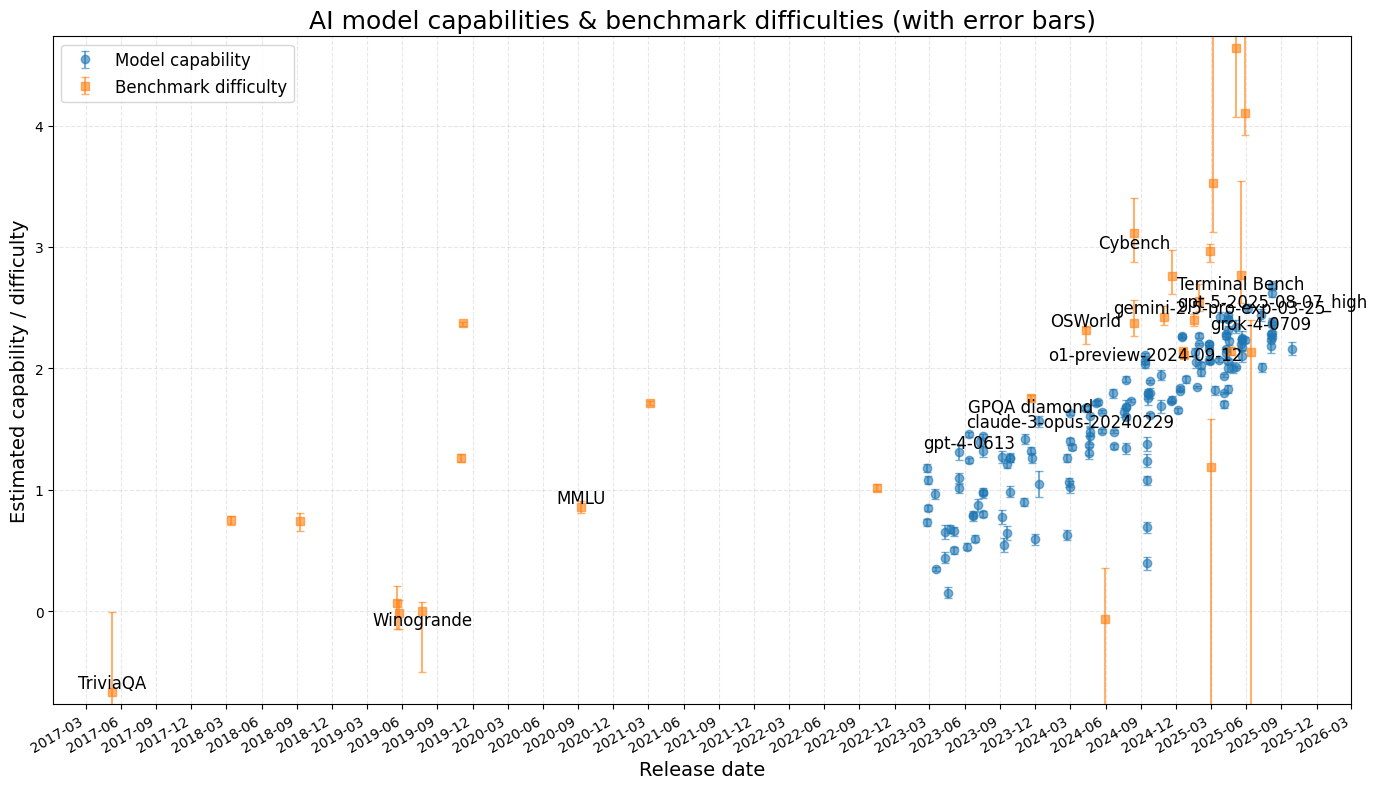


ERROR BAR STATISTICS

Model Capabilities:
  Mean error (minus): 0.0324
  Mean error (plus):  0.0322
  Median error (minus): 0.0320
  Median error (plus):  0.0313
  Max error (minus): 0.1051
  Max error (plus):  0.1076

Benchmark Difficulties:
  Mean error (minus): 0.5620
  Mean error (plus):  0.3756
  Median error (minus): 0.1033
  Median error (plus):  0.0857
  Max error (minus): 4.7781
  Max error (plus):  3.0077


In [9]:
# ── PLOT WITH ERROR BARS ──────────────────────────────────────────────────

# Merge error bars with the original data
cap_df_with_errors = df_cm1.merge(
    capability_errors[['model', 'error_minus', 'error_plus']], 
    on='model', 
    how='left'
)
bench_df_with_errors = df_db1.merge(
    difficulty_errors[['benchmark_name', 'error_minus', 'error_plus']], 
    on='benchmark_name', 
    how='left'
)

# Prepare data
cap_df_with_errors["date_obj"] = pd.to_datetime(cap_df_with_errors["date"])
cap_df_with_errors.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df_with_errors["date_obj"])
cap_values = cap_df_with_errors["estimated_capability"]

bench_df_with_errors["date_obj"] = pd.to_datetime(bench_df_with_errors["benchmark_release_date"])
bench_df_with_errors.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df_with_errors["date_obj"])
bench_values = bench_df_with_errors["estimated_difficulty"]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot with error bars
ax.errorbar(cap_dates_num, cap_values,
            yerr=[cap_df_with_errors["error_minus"], cap_df_with_errors["error_plus"]],
            fmt='o', markersize=6, capsize=3, capthick=1,
            color='tab:blue', ecolor='tab:blue', alpha=0.6,
            label='Model capability')

ax.errorbar(bench_dates_num, bench_values,
            yerr=[bench_df_with_errors["error_minus"], bench_df_with_errors["error_plus"]],
            fmt='s', markersize=6, capsize=3, capthick=1,
            color='tab:orange', ecolor='tab:orange', alpha=0.6,
            label='Benchmark difficulty')

# Annotate selected points (same as before)
annotate_models = {
    "gpt-5-2025-08-07_high",
    "claude-opus-4-20250514_32K",
    "grok-4-0709",
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df_with_errors["model"])):
    if name not in annotate_models:
        continue
    y_offset = 0.05 if i % 2 == 0 else -0.05
    va = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df_with_errors["benchmark_name"])):
    if name not in annotate_benchmarks:
        continue
    y_offset = 0.05 if i % 2 == 0 else -0.05
    va = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# Axes cosmetics
ax.set_xlabel("Release date", fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties (with error bars)", fontsize=18)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

min_y = min(cap_values.min(), bench_values.min()) - 0.1
max_y = max(cap_values.max(), bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("outputs/notebooks/capabilities_and_benchmarks_with_error_bars.pdf")
plt.show()

# Print some statistics about error bars
print("\n" + "="*60)
print("ERROR BAR STATISTICS")
print("="*60)
print(f"\nModel Capabilities:")
print(f"  Mean error (minus): {capability_errors['error_minus'].mean():.4f}")
print(f"  Mean error (plus):  {capability_errors['error_plus'].mean():.4f}")
print(f"  Median error (minus): {capability_errors['error_minus'].median():.4f}")
print(f"  Median error (plus):  {capability_errors['error_plus'].median():.4f}")
print(f"  Max error (minus): {capability_errors['error_minus'].max():.4f}")
print(f"  Max error (plus):  {capability_errors['error_plus'].max():.4f}")

print(f"\nBenchmark Difficulties:")
print(f"  Mean error (minus): {difficulty_errors['error_minus'].mean():.4f}")
print(f"  Mean error (plus):  {difficulty_errors['error_plus'].mean():.4f}")
print(f"  Median error (minus): {difficulty_errors['error_minus'].median():.4f}")
print(f"  Median error (plus):  {difficulty_errors['error_plus'].median():.4f}")
print(f"  Max error (minus): {difficulty_errors['error_minus'].max():.4f}")
print(f"  Max error (plus):  {difficulty_errors['error_plus'].max():.4f}")


# Growth rate

Annual growth rate: 0.6017
95% CI for slope: [0.5409, 0.6625]
R^2: 0.9616


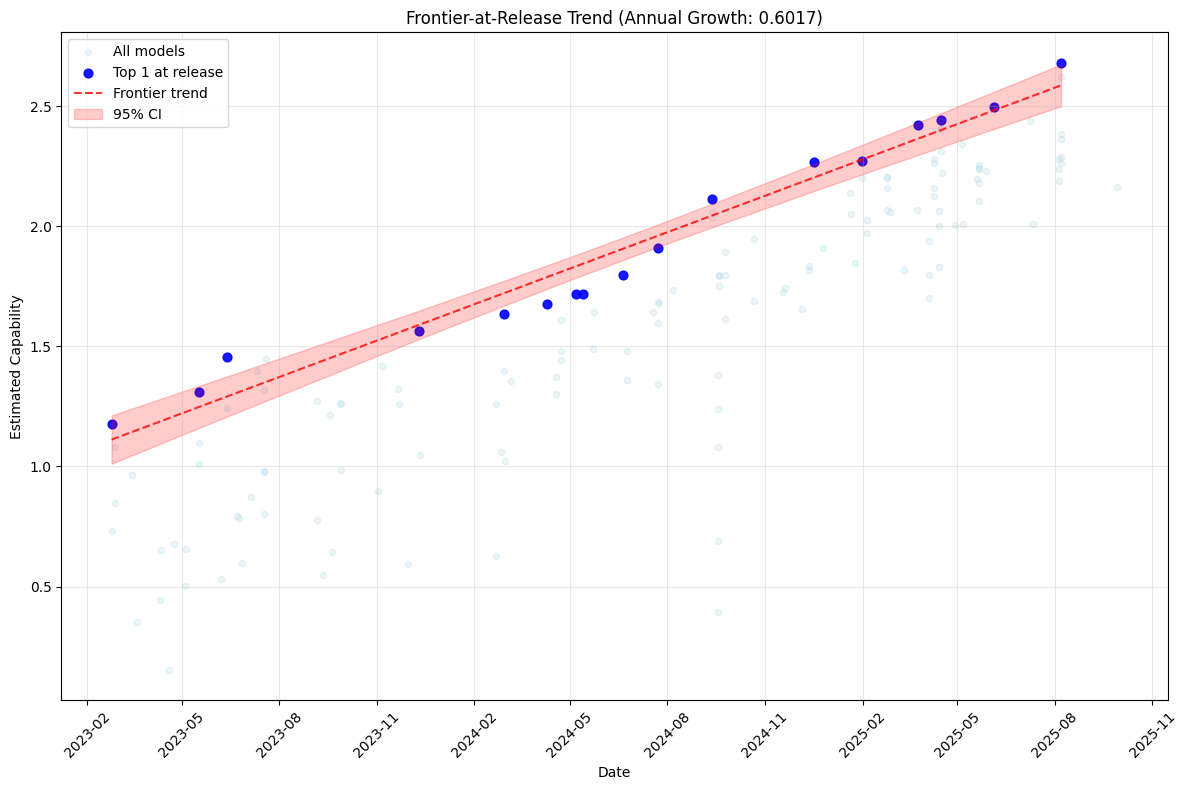

In [13]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

# Identify models that were SOTA (top-N) at their release and fit a trend
TOP_N_AT_RELEASE = 1  # change to >1 if you want top-N frontier, not strict SOTA

# Prepare data
df_all = df_cm1.copy()
# Ensure datetime
if 'date_obj' not in df_all.columns or not np.issubdtype(df_all['date_obj'].dtype, np.datetime64):
    df_all['date_obj'] = pd.to_datetime(df_all['date'])

df_all = df_all.dropna(subset=['date_obj', 'estimated_capability']).sort_values('date_obj').reset_index(drop=True)

# Compute frontier-at-release
frontier_rows = []
for _, row in df_all.iterrows():
    release_date = row['date_obj']
    available = df_all[df_all['date_obj'] <= release_date]
    top_at_release = available.nlargest(TOP_N_AT_RELEASE, 'estimated_capability')
    if row['model'] in top_at_release['model'].values:
        frontier_rows.append(row)

df_frontier = pd.DataFrame(frontier_rows).sort_values('date_obj').reset_index(drop=True)

# Fit linear trend through frontier points
if len(df_frontier) >= 2:
    X = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y = df_frontier['estimated_capability'].values
    lr = LinearRegression()
    lr.fit(X, y)
    slope_per_year = lr.coef_[0] * 365.25
    r2 = lr.score(X, y)

    # statsmodels for confidence intervals
    X_sm = sm.add_constant(X.flatten())
    model_sm = sm.OLS(y, X_sm).fit()
    predictions = model_sm.get_prediction(X_sm)
    ci_lower = predictions.conf_int()[:, 0]
    ci_upper = predictions.conf_int()[:, 1]
    
    # Print with CI
    print(f"Annual growth rate: {slope_per_year:.4f}")
    print(f"95% CI for slope: [{model_sm.params[1]*365.25 - 1.96*model_sm.bse[1]*365.25:.4f}, "
          f"{model_sm.params[1]*365.25 + 1.96*model_sm.bse[1]*365.25:.4f}]")
    print(f"R^2: {r2:.4f}")
    
    # Plot with confidence bands
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(df_all['date_obj'], df_all['estimated_capability'], 
               alpha=0.25, s=20, label='All models', color='lightblue')
    ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], 
               alpha=0.9, s=40, label=f'Top {TOP_N_AT_RELEASE} at release', color='blue')
    ax.plot(df_frontier['date_obj'], lr.predict(X), 'r--', alpha=0.8, label='Frontier trend')
    
    # Add confidence band
    ax.fill_between(df_frontier['date_obj'], ci_lower, ci_upper, 
                     alpha=0.2, color='red', label='95% CI')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'Frontier-at-Release Trend (Annual Growth: {slope_per_year:.4f})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("outputs/notebooks/frontier_at_release_trend.pdf", dpi=300, bbox_inches='tight')
    plt.show()

else:
    lr = None
    slope_per_year = np.nan
    r2 = np.nan

# print("SOTA-at-release points:", len(df_frontier))
# print(f"Annual growth rate (slope): {slope_per_year:.4f}")
# print(f"R^2: {r2:.4f}")
# if len(df_frontier) > 0:
#     print(f"Span: {df_frontier.iloc[0]['date']} {df_frontier.iloc[-1]['date']}")

# # Plot: all points, frontier points, and trendline
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.scatter(df_all['date_obj'], df_all['estimated_capability'], alpha=0.25, s=20, label='All models', color='lightblue')
# ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], alpha=0.9, s=40, label=f'Top {TOP_N_AT_RELEASE} at release', color='blue')

# if lr is not None:
#     X_plot = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
#     y_pred = lr.predict(X_plot)
#     ax.plot(df_frontier['date_obj'], y_pred, 'r--', alpha=0.8, label='Frontier trend')

# ax.set_xlabel('Date')
# ax.set_ylabel('Estimated Capability')
# ax.set_title('Frontier-at-Release Trend and Annual Growth Rate')
# ax.grid(True, alpha=0.3)
# ax.legend()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


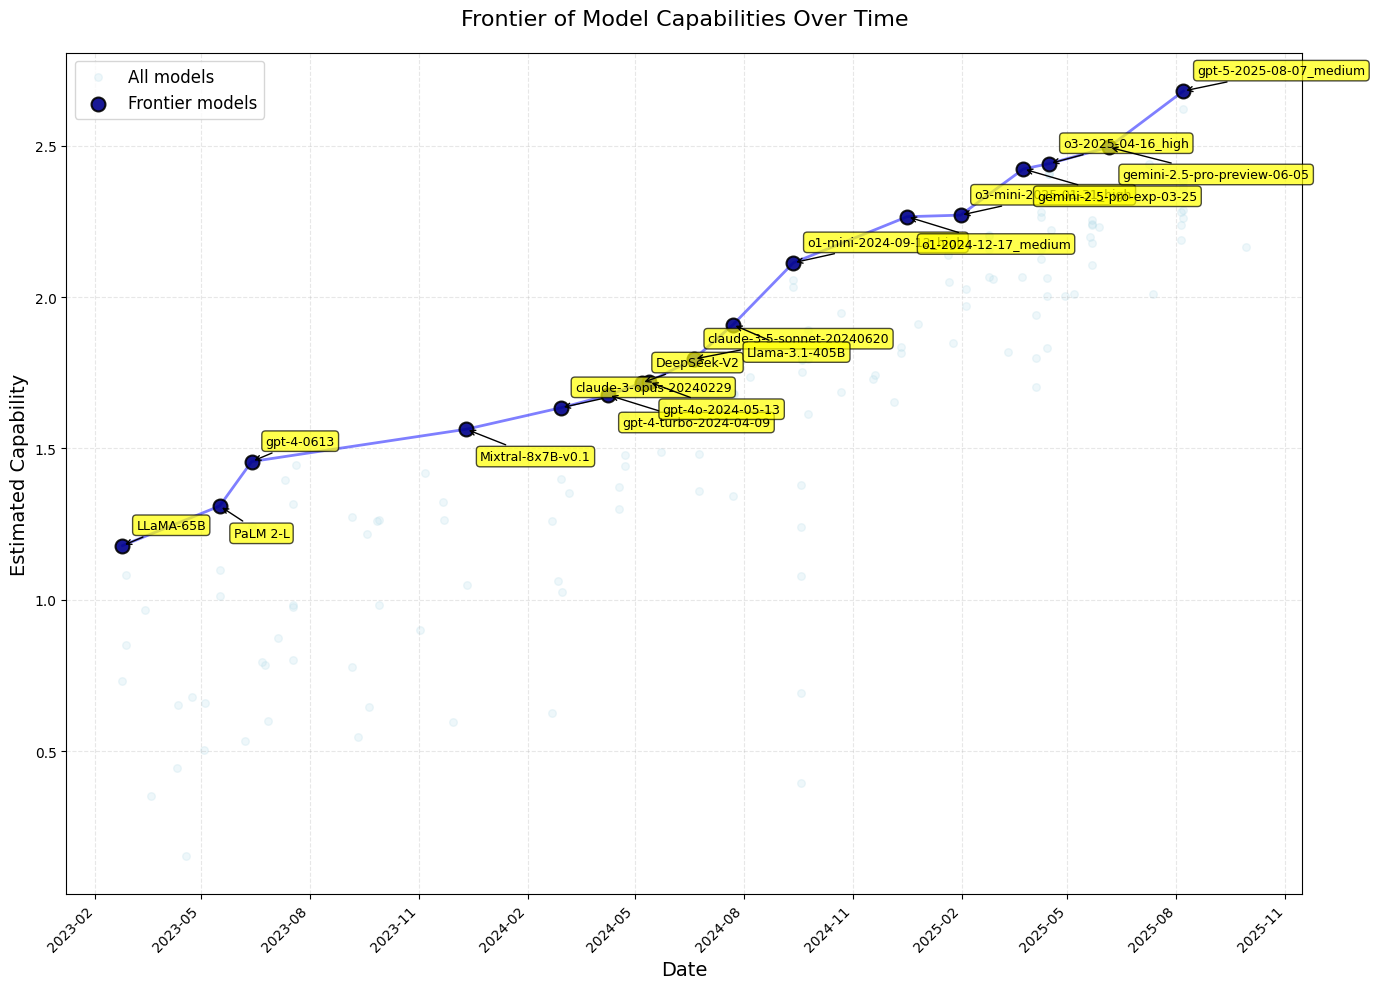


Frontier Models (SOTA at release):
2023-02-24: LLaMA-65B                                     (capability: 1.1787)
2023-05-17: PaLM 2-L                                      (capability: 1.3097)
2023-06-13: gpt-4-0613                                    (capability: 1.4565)
2023-12-11: Mixtral-8x7B-v0.1                             (capability: 1.5633)
2024-02-29: claude-3-opus-20240229                        (capability: 1.6343)
2024-04-09: gpt-4-turbo-2024-04-09                        (capability: 1.6758)
2024-05-07: DeepSeek-V2                                   (capability: 1.7162)
2024-05-13: gpt-4o-2024-05-13                             (capability: 1.7197)
2024-06-20: claude-3-5-sonnet-20240620                    (capability: 1.7950)
2024-07-23: Llama-3.1-405B                                (capability: 1.9086)
2024-09-12: o1-mini-2024-09-12_high                       (capability: 2.1133)
2024-12-17: o1-2024-12-17_medium                          (capability: 2.2654)
2025-01-31: o3-m

In [14]:
# Plot frontier of model capabilities over time with model names
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Use the frontier data computed in the previous cell
if len(df_frontier) > 0:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot all models in light color
    ax.scatter(df_all['date_obj'], df_all['estimated_capability'], 
               alpha=0.2, s=30, label='All models', color='lightblue', zorder=1)
    
    # Plot frontier models prominently
    ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], 
               alpha=0.9, s=100, label='Frontier models', color='darkblue', 
               edgecolors='black', linewidths=1.5, zorder=3)
    
    # Draw line connecting frontier points
    ax.plot(df_frontier['date_obj'], df_frontier['estimated_capability'], 
            'b-', alpha=0.5, linewidth=2, zorder=2)
    
    # Annotate each frontier model with its name
    for idx, row in df_frontier.iterrows():
        # Alternate text position to avoid overlap
        xytext_offset = (10, 10) if idx % 2 == 0 else (10, -15)
        va = 'bottom' if idx % 2 == 0 else 'top'
        
        ax.annotate(row['model'], 
                   xy=(row['date_obj'], row['estimated_capability']),
                   xytext=xytext_offset,
                   textcoords='offset points',
                   fontsize=9,
                   ha='left',
                   va=va,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='black'),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1))
    
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Estimated Capability', fontsize=14)
    ax.set_title('Frontier of Model Capabilities Over Time', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=12, loc='upper left')
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig("outputs/notebooks/frontier_capabilities_over_time.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print frontier models
    print("\nFrontier Models (SOTA at release):")
    print("="*80)
    for idx, row in df_frontier.iterrows():
        print(f"{row['date']}: {row['model']:45s} (capability: {row['estimated_capability']:.4f})")
    
    print(f"\nTotal frontier models: {len(df_frontier)}")
else:
    print("No frontier data available. Please run the previous cell first.")

# Checking fit

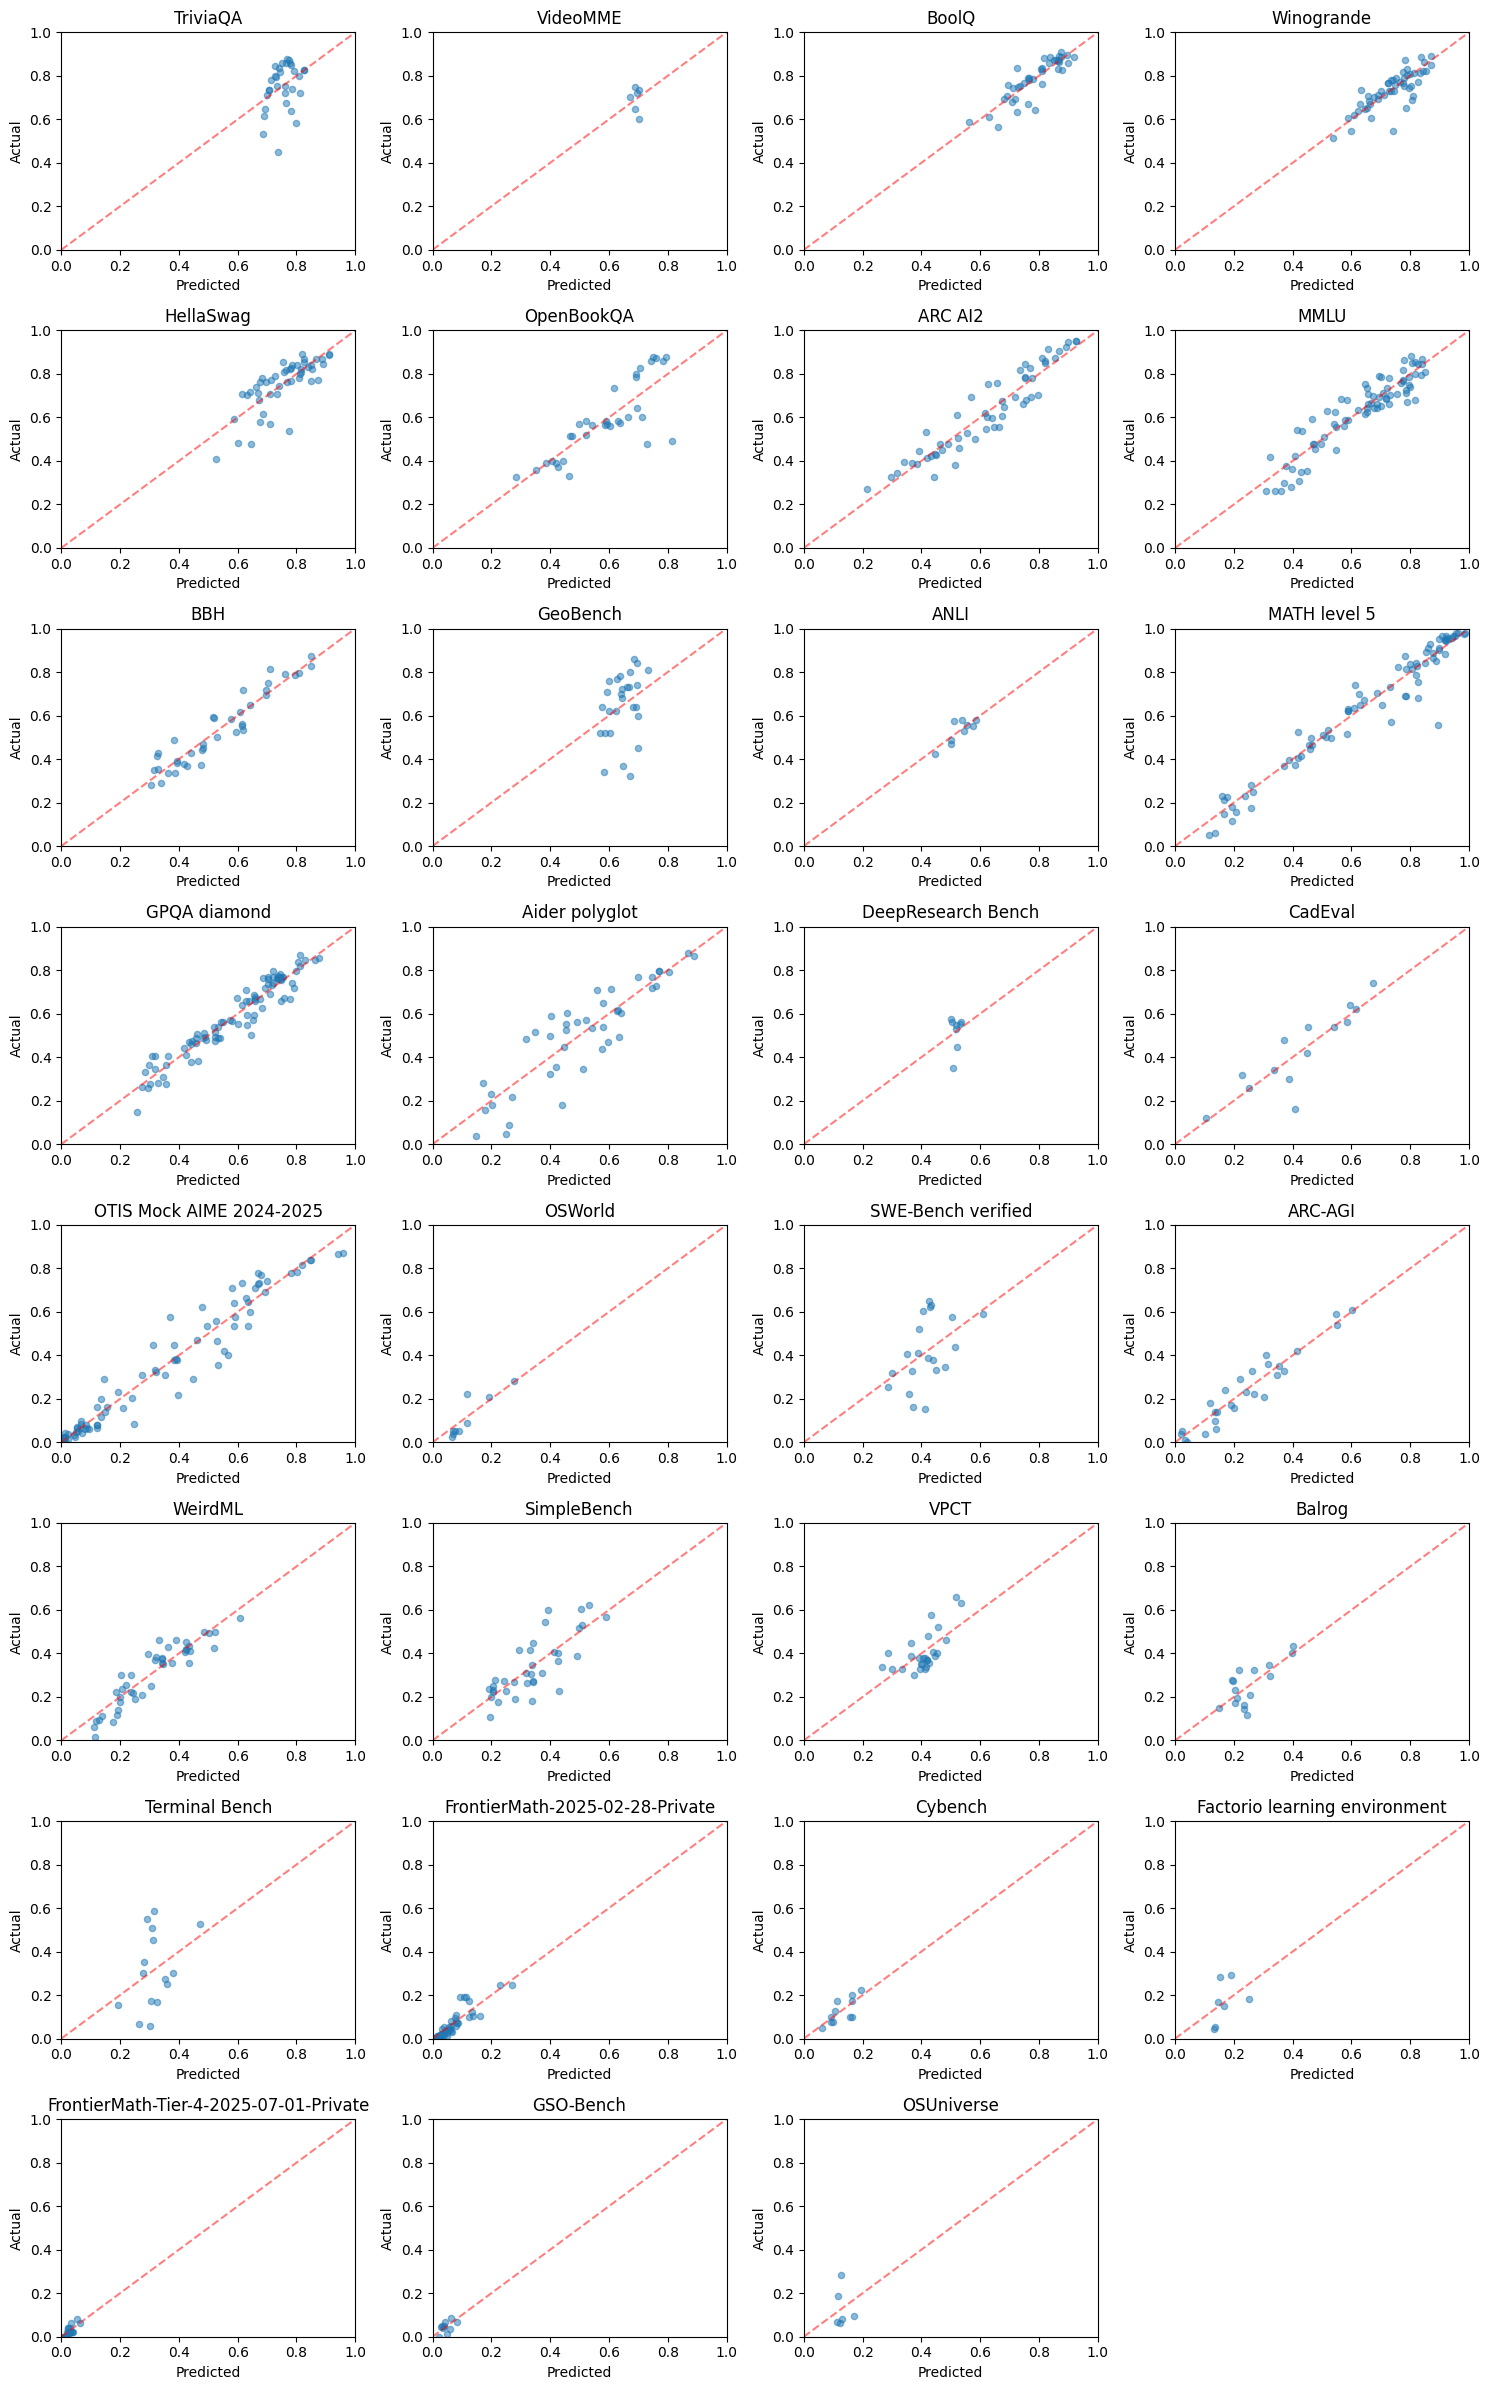

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# Get unique benchmarks
benchmarks = df_db1['benchmark_name'].unique()

# Create subplots
n_benchmarks = len(benchmarks)
n_cols = 4
n_rows = (n_benchmarks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

# Loop through each benchmark
for idx, benchmark in enumerate(benchmarks):
    ax = axes[idx]
    
    # Get data for this benchmark
    bench_data = df1[df1['benchmark'] == benchmark].copy()
    
    # Get benchmark parameters
    bench_params = df_db1[df_db1['benchmark_name'] == benchmark].iloc[0]
    D = bench_params['estimated_difficulty']
    alpha = bench_params['estimated_slope']
    
    # Merge with model capabilities
    bench_data = bench_data.merge(df_cm1[['model', 'estimated_capability']], on='model', how='left')
    
    # Calculate predicted performance
    bench_data['predicted'] = logistic(alpha * (bench_data['estimated_capability'] - D))
    
    # Plot
    ax.scatter(bench_data['predicted'], bench_data['performance'], alpha=0.5, s=20)
    ax.plot([0, 1], [0, 1], 'r--', alpha=0.5)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(benchmark)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Hide unused subplots
for idx in range(n_benchmarks, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig("outputs/notebooks/benchmark_fit_scatter_grid.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
import plotly.graph_objects as go

def plot_benchmark_performance_interactive(benchmark_name, df_data=df1, df_capabilities=df_cm1, df_benchmarks=df_db1):
    """
    Create an interactive plotly scatter plot comparing actual vs predicted performance
    for a specific benchmark with model names shown on hover.
    
    Parameters:
    -----------
    benchmark_name : str
        Name of the benchmark to plot
    df_data : DataFrame
        DataFrame containing performance data (default: df1)
    df_capabilities : DataFrame
        DataFrame containing model capabilities (default: df_cm1)
    df_benchmarks : DataFrame
        DataFrame containing benchmark parameters (default: df_db1)
    """
    
    def logistic(x):
        return 1.0 / (1.0 + np.exp(-x))
    
    # Get data for this benchmark
    bench_data = df_data[df_data['benchmark'] == benchmark_name].copy()
    
    if len(bench_data) == 0:
        print(f"No data found for benchmark: {benchmark_name}")
        print(f"Available benchmarks: {sorted(df_data['benchmark'].unique())}")
        return
    
    # Get benchmark parameters
    bench_params_df = df_benchmarks[df_benchmarks['benchmark_name'] == benchmark_name]
    if len(bench_params_df) == 0:
        print(f"No parameters found for benchmark: {benchmark_name}")
        return
    
    bench_params = bench_params_df.iloc[0]
    D = bench_params['estimated_difficulty']
    alpha = bench_params['estimated_slope']
    
    # Merge with model capabilities
    bench_data = bench_data.merge(df_capabilities[['model', 'estimated_capability']], on='model', how='left')
    
    # Calculate predicted performance
    bench_data['predicted'] = logistic(alpha * (bench_data['estimated_capability'] - D))
    
    # Create the scatter plot
    fig = go.Figure()
    
    # Add scatter points
    fig.add_trace(go.Scatter(
        x=bench_data['predicted'],
        y=bench_data['performance'],
        mode='markers',
        marker=dict(
            size=8,
            color='blue',
            opacity=0.6,
            line=dict(width=0.5, color='white')
        ),
        text=bench_data['model'],
        hovertemplate='<b>%{text}</b><br>' +
                      'Predicted: %{x:.3f}<br>' +
                      'Actual: %{y:.3f}<br>' +
                      '<extra></extra>',
        name='Models'
    ))
    
    # Add diagonal line (perfect prediction)
    fig.add_trace(go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        line=dict(color='red', dash='dash', width=2),
        name='Perfect Prediction',
        hovertemplate='<extra></extra>'
    ))
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f'Actual vs Predicted Performance: {benchmark_name}<br>' +
                 f'<sub>Difficulty: {D:.3f}, Slope: {alpha:.3f}</sub>',
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(
            title='Predicted Performance',
            range=[0, 1],
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title='Actual Performance',
            range=[0, 1],
            gridcolor='lightgray'
        ),
        width=700,
        height=700,
        hovermode='closest',
        plot_bgcolor='white',
        showlegend=True
    )
    
    # fig.write_image("outputs/notebooks/benchmark_performance_interactive_swe_bench.pdf")
    fig.show()
    
    # Print some statistics
    residuals = bench_data['performance'] - bench_data['predicted']
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))
    
    print(f"\nBenchmark: {benchmark_name}")
    print(f"Number of models: {len(bench_data)}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")


# Example usage - change the benchmark name to plot different benchmarks
# Available benchmarks can be found in df_db1['benchmark_name'].unique()
plot_benchmark_performance_interactive('SWE-Bench verified')

# Uncomment to see all available benchmarks:
# print("\nAvailable benchmarks:")
# for benchmark in sorted(df_db1['benchmark_name'].unique()):
#     print(f"  - {benchmark}")



Benchmark: SWE-Bench verified
Number of models: 20
RMSE: 0.1356
MAE: 0.1119


Figure saved to: outputs/notebooks/benchmark_comparison_swe_geo.pdf


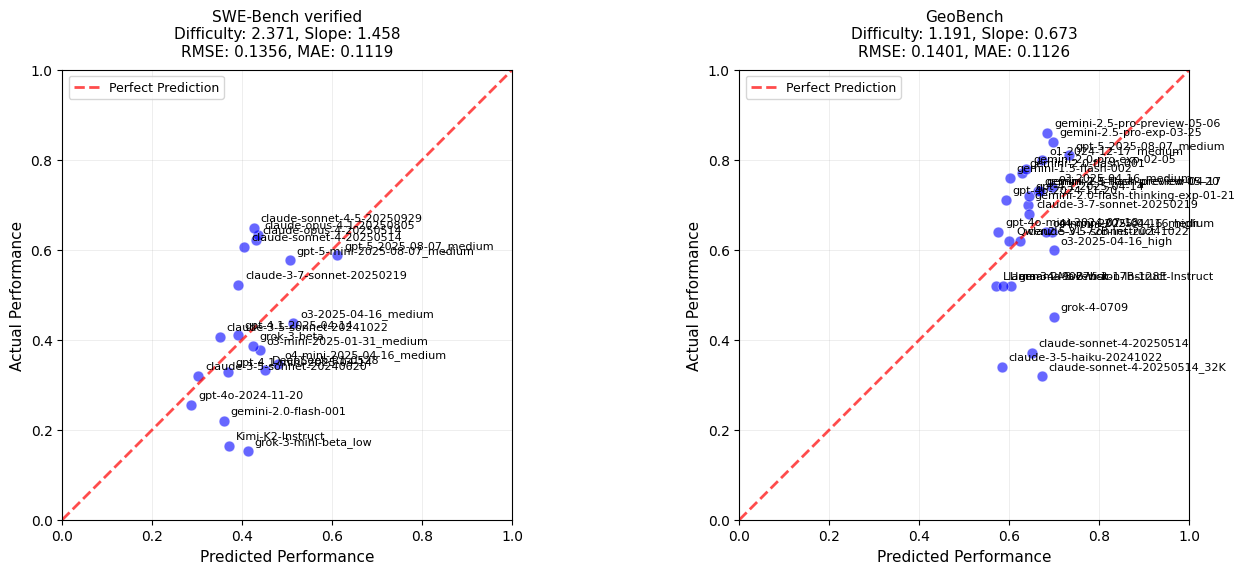


Summary Statistics:

SWE-Bench verified:
  Number of models: 20
  RMSE: 0.1356
  MAE: 0.1119

GeoBench:
  Number of models: 27
  RMSE: 0.1401
  MAE: 0.1126


In [4]:
def plot_two_benchmarks_comparison(benchmark1_name, benchmark2_name, 
                                   df_data=df1, df_capabilities=df_cm1, df_benchmarks=df_db1,
                                   models_to_annotate=None, annotate_all=False,
                                   figsize=(14, 6), save_path=None):
    """
    Create a side-by-side comparison of two benchmarks with model annotations.
    
    Parameters:
    -----------
    benchmark1_name : str
        Name of the first benchmark to plot
    benchmark2_name : str
        Name of the second benchmark to plot
    df_data : DataFrame
        DataFrame containing performance data (default: df1)
    df_capabilities : DataFrame
        DataFrame containing model capabilities (default: df_cm1)
    df_benchmarks : DataFrame
        DataFrame containing benchmark parameters (default: df_db1)
    models_to_annotate : list, optional
        List of model names to annotate. If None and annotate_all is False, no annotations.
    annotate_all : bool, default False
        If True, annotate all models (overrides models_to_annotate)
    figsize : tuple, default (14, 6)
        Figure size as (width, height)
    save_path : str, optional
        If provided, save the figure to this path
    """
    
    def logistic(x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def prepare_benchmark_data(benchmark_name):
        """Helper function to prepare data for one benchmark"""
        # Get data for this benchmark
        bench_data = df_data[df_data['benchmark'] == benchmark_name].copy()
        
        if len(bench_data) == 0:
            raise ValueError(f"No data found for benchmark: {benchmark_name}")
        
        # Get benchmark parameters
        bench_params_df = df_benchmarks[df_benchmarks['benchmark_name'] == benchmark_name]
        if len(bench_params_df) == 0:
            raise ValueError(f"No parameters found for benchmark: {benchmark_name}")
        
        bench_params = bench_params_df.iloc[0]
        D = bench_params['estimated_difficulty']
        alpha = bench_params['estimated_slope']
        
        # Merge with model capabilities
        bench_data = bench_data.merge(df_capabilities[['model', 'estimated_capability']], 
                                      on='model', how='left')
        
        # Calculate predicted performance
        bench_data['predicted'] = logistic(alpha * (bench_data['estimated_capability'] - D))
        
        return bench_data, D, alpha
    
    # Prepare data for both benchmarks
    data1, D1, alpha1 = prepare_benchmark_data(benchmark1_name)
    data2, D2, alpha2 = prepare_benchmark_data(benchmark2_name)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    def plot_single_benchmark(ax, bench_data, benchmark_name, D, alpha):
        """Helper function to plot a single benchmark"""
        # Plot scatter points
        ax.scatter(bench_data['predicted'], bench_data['performance'], 
                  alpha=0.6, s=60, c='blue', edgecolors='white', linewidths=0.5)
        
        # Plot diagonal line (perfect prediction)
        ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction', alpha=0.7)
        
        # Add annotations
        if annotate_all:
            models_to_label = bench_data['model'].tolist()
        elif models_to_annotate is not None:
            models_to_label = [m for m in models_to_annotate if m in bench_data['model'].values]
        else:
            models_to_label = []
        
        for model in models_to_label:
            model_data = bench_data[bench_data['model'] == model]
            if len(model_data) > 0:
                x = model_data['predicted'].iloc[0]
                y = model_data['performance'].iloc[0]
                ax.annotate(model, xy=(x, y), xytext=(5, 5), 
                           textcoords='offset points', fontsize=8,
                        #    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3),
                           ha='left')
        
        # Calculate and display statistics
        residuals = bench_data['performance'] - bench_data['predicted']
        rmse = np.sqrt(np.mean(residuals**2))
        mae = np.mean(np.abs(residuals))
        
        # Set labels and title
        ax.set_xlabel('Predicted Performance', fontsize=11)
        ax.set_ylabel('Actual Performance', fontsize=11)
        ax.set_title(f'{benchmark_name}\nDifficulty: {D:.3f}, Slope: {alpha:.3f}\n' +
                    f'RMSE: {rmse:.4f}, MAE: {mae:.4f}', fontsize=11, pad=10)
        
        # Set axis limits
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        # Add grid
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Add legend
        ax.legend(loc='upper left', fontsize=9)
        
        # Equal aspect ratio
        ax.set_aspect('equal')
        
        return rmse, mae
    
    # Plot both benchmarks
    rmse1, mae1 = plot_single_benchmark(ax1, data1, benchmark1_name, D1, alpha1)
    rmse2, mae2 = plot_single_benchmark(ax2, data2, benchmark2_name, D2, alpha2)
    
    # Overall title
    fig.suptitle('', 
                fontsize=14, fontweight='bold', y=1.00)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"\n{benchmark1_name}:")
    print(f"  Number of models: {len(data1)}")
    print(f"  RMSE: {rmse1:.4f}")
    print(f"  MAE: {mae1:.4f}")
    print(f"\n{benchmark2_name}:")
    print(f"  Number of models: {len(data2)}")
    print(f"  RMSE: {rmse2:.4f}")
    print(f"  MAE: {mae2:.4f}")


# Example usage:
# Plot two benchmarks with specific model annotations
models_to_label = ['gpt-4o-2024-11-20', 'claude-3-5-sonnet-20241022', 'o1-2024-12-17_high']
plot_two_benchmarks_comparison(
    'SWE-Bench verified', 
    'GeoBench',
    # models_to_annotate=models_to_label,
    annotate_all=True,
    save_path='outputs/notebooks/benchmark_comparison_swe_geo.pdf'
)

# Uncomment to annotate all models (warning: can be crowded!)
# plot_two_benchmarks_comparison(
#     'SWE-Bench verified', 
#     'GeoBench',
#     annotate_all=True
# )


In [19]:
set(scores_df["benchmark"])

{'ANLI',
 'ARC AI2',
 'ARC-AGI',
 'Aider polyglot',
 'BBH',
 'Balrog',
 'BoolQ',
 'CadEval',
 'Cybench',
 'DeepResearch Bench',
 'Factorio learning environment',
 'FrontierMath-2025-02-28-Private',
 'GPQA diamond',
 'GSO-Bench',
 'GeoBench',
 'HellaSwag',
 'MATH level 5',
 'MMLU',
 'OSUniverse',
 'OSWorld',
 'OTIS Mock AIME 2024-2025',
 'OpenBookQA',
 'SWE-Bench verified',
 'SimpleBench',
 'Terminal Bench',
 'TriviaQA',
 'VPCT',
 'VideoMME',
 'WeirdML',
 'Winogrande'}

In [20]:
scores_df[scores_df['benchmark'] == "SWE-Bench verified"]

,model_id,benchmark_id,performance,benchmark,benchmark_release_date,optimized,is_math,is_coding,model,date,source
203,m13,b5,0.320,SWE-Bench verified,2024-08-13,True,False,True,claude-3-5-sonnet-20240620,2024-06-20,Epoch evaluations
483,m36,b5,0.378,SWE-Bench verified,2024-08-13,True,False,True,o3-mini-2025-01-31_medium,2025-01-31,Epoch evaluations
513,m39,b5,0.254,SWE-Bench verified,2024-08-13,True,False,True,gpt-4o-2024-11-20,2024-11-20,Epoch evaluations
533,m40,b5,0.220,SWE-Bench verified,2024-08-13,True,False,True,gemini-2.0-flash-001,2025-02-05,Epoch evaluations
575,m46,b5,0.522,SWE-Bench verified,2024-08-13,True,False,True,claude-3-7-sonnet-20250219,2025-02-24,Epoch evaluations
662,m59,b5,0.152,SWE-Bench verified,2024-08-13,True,False,True,grok-3-mini-beta_low,2025-04-09,Epoch evaluations
683,m60,b5,0.410,SWE-Bench verified,2024-08-13,True,False,True,gpt-4.1-2025-04-14,2025-04-14,Epoch evaluations
699,m62,b5,0.328,SWE-Bench verified,2024-08-13,True,False,True,gpt-4.1-mini-2025-04-14,2025-04-14,Epoch evaluations
733,m66,b5,0.622,SWE-Bench verified,2024-08-13,True,False,True,claude-opus-4-20250514,2025-05-22,Epoch evaluations
745,m67,b5,0.606,SWE-Bench verified,2024-08-13,True,False,True,claude-sonnet-4-20250514,2025-05-22,Epoch evaluations


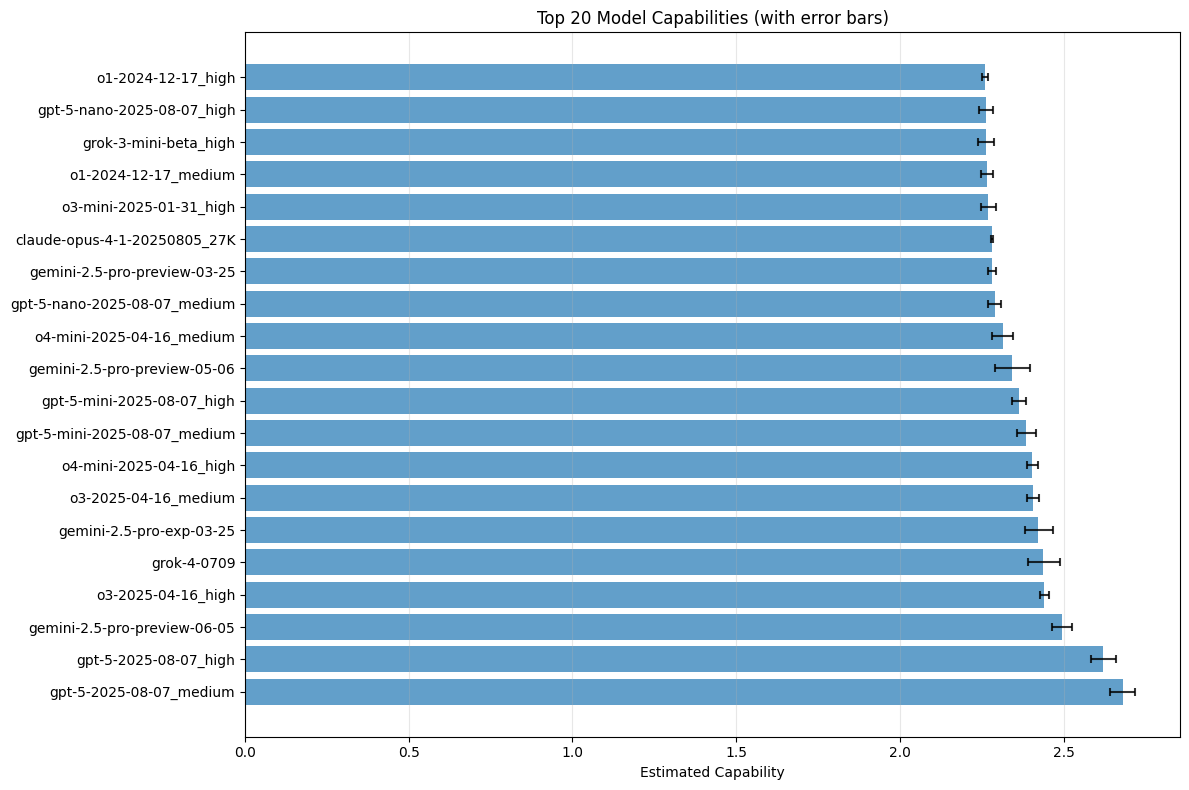


Top 20 Models by Capability:
 1. gpt-5-2025-08-07_medium                       2.6806 (±0.0384, +0.0391)
 2. gpt-5-2025-08-07_high                         2.6218 (±0.0365, +0.0378)
 3. gemini-2.5-pro-preview-06-05                  2.4952 (±0.0301, +0.0312)
 4. o3-2025-04-16_high                            2.4409 (±0.0133, +0.0137)
 5. grok-4-0709                                   2.4385 (±0.0464, +0.0503)
 6. gemini-2.5-pro-exp-03-25                      2.4232 (±0.0410, +0.0437)
 7. o3-2025-04-16_medium                          2.4071 (±0.0182, +0.0186)
 8. o4-mini-2025-04-16_high                       2.4049 (±0.0158, +0.0162)
 9. gpt-5-mini-2025-08-07_medium                  2.3849 (±0.0281, +0.0308)
10. gpt-5-mini-2025-08-07_high                    2.3638 (±0.0200, +0.0214)
11. gemini-2.5-pro-preview-05-06                  2.3418 (±0.0516, +0.0555)
12. o4-mini-2025-04-16_medium                     2.3136 (±0.0320, +0.0315)
13. gpt-5-nano-2025-08-07_medium                  2.2891 (

In [23]:
# Model Capabilities Ranking - Top 20 Models
fig, ax = plt.subplots(figsize=(12, 8))

# Get data with valid capabilities
df_capabilities_clean = df_cm1.dropna(subset=['date', 'estimated_capability'])
top_models = df_capabilities_clean.nlargest(20, 'estimated_capability')

# Merge with error bars
top_models_with_errors = top_models.merge(
    capability_errors[['model', 'error_minus', 'error_plus']], 
    on='model', 
    how='left'
)

y_pos = np.arange(len(top_models_with_errors))

# Create horizontal bar chart with error bars
ax.barh(y_pos, top_models_with_errors['estimated_capability'], alpha=0.7)
ax.errorbar(top_models_with_errors['estimated_capability'], y_pos,
            xerr=[top_models_with_errors['error_minus'], top_models_with_errors['error_plus']],
            fmt='none', ecolor='black', capsize=3, capthick=1.5, alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_models_with_errors['model'])
ax.set_xlabel('Estimated Capability')
ax.set_title('Top 20 Model Capabilities (with error bars)')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig("outputs/notebooks/model_capabilities_ranking.pdf", dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 20 Models by Capability:")
for i, (idx, row) in enumerate(top_models_with_errors.iterrows()):
    print(f"{i+1:2d}. {row['model']:45s} {row['estimated_capability']:.4f} (±{row['error_minus']:.4f}, +{row['error_plus']:.4f})")


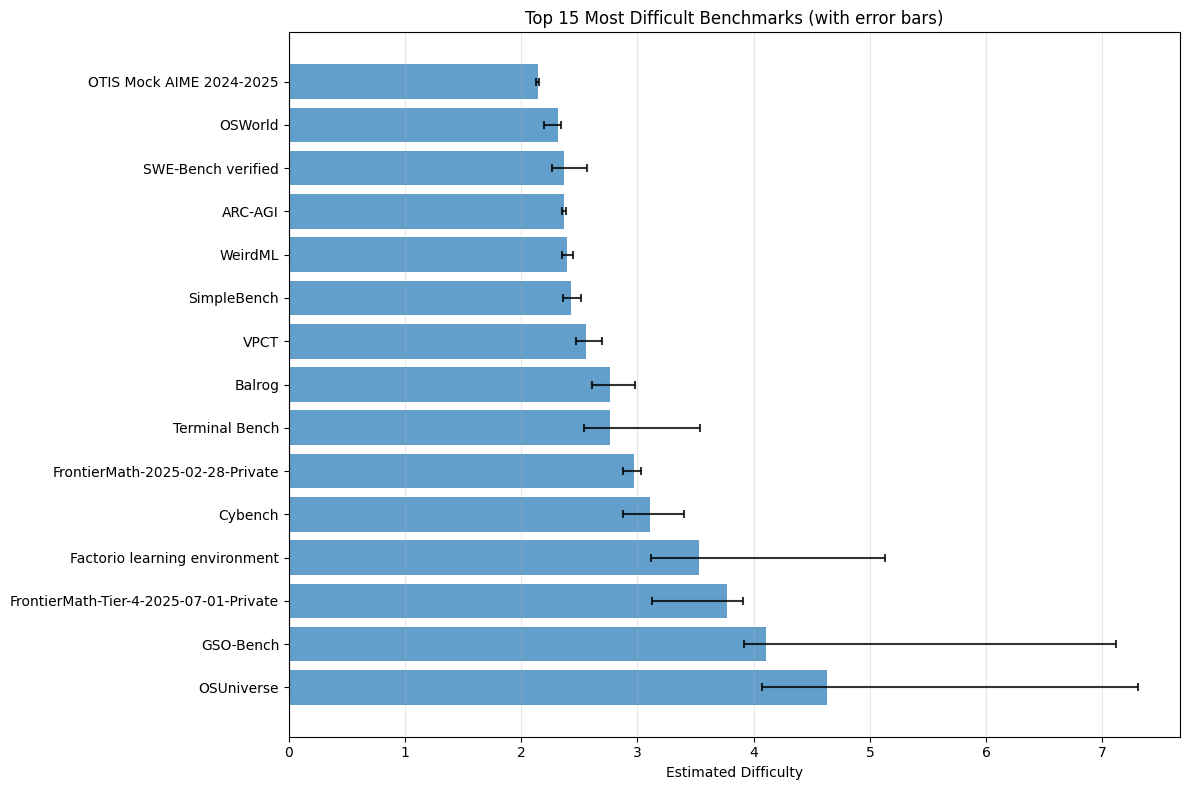


Top 15 Most Difficult Benchmarks:
 1. OSUniverse                                    4.6342 (±0.5633, +2.6692)
 2. GSO-Bench                                     4.1059 (±0.1856, +3.0077)
 3. FrontierMath-Tier-4-2025-07-01-Private        3.7695 (±0.6442, +0.1345)
 4. Factorio learning environment                 3.5278 (±0.4074, +1.6013)
 5. Cybench                                       3.1113 (±0.2356, +0.2891)
 6. FrontierMath-2025-02-28-Private               2.9661 (±0.0870, +0.0615)
 7. Terminal Bench                                2.7659 (±0.2281, +0.7761)
 8. Balrog                                        2.7610 (±0.1485, +0.2161)
 9. VPCT                                          2.5589 (±0.0876, +0.1362)
10. SimpleBench                                   2.4240 (±0.0666, +0.0857)
11. WeirdML                                       2.3969 (±0.0445, +0.0501)
12. ARC-AGI                                       2.3719 (±0.0197, +0.0116)
13. SWE-Bench verified                            2.3

In [24]:
# Benchmark Difficulties Ranking - Top 15 Most Difficult Benchmarks
fig, ax = plt.subplots(figsize=(12, 8))

# Sort benchmarks by difficulty and get top 15
df_benchmarks_sorted = df_db1.sort_values('estimated_difficulty', ascending=True)
top_difficult = df_benchmarks_sorted.nlargest(15, 'estimated_difficulty')

# Merge with error bars
top_difficult_with_errors = top_difficult.merge(
    difficulty_errors[['benchmark_name', 'error_minus', 'error_plus']], 
    on='benchmark_name', 
    how='left'
)

y_pos = np.arange(len(top_difficult_with_errors))

# Create horizontal bar chart with error bars
ax.barh(y_pos, top_difficult_with_errors['estimated_difficulty'], alpha=0.7)
ax.errorbar(top_difficult_with_errors['estimated_difficulty'], y_pos,
            xerr=[top_difficult_with_errors['error_minus'], top_difficult_with_errors['error_plus']],
            fmt='none', ecolor='black', capsize=3, capthick=1.5, alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_difficult_with_errors['benchmark_name'])
ax.set_xlabel('Estimated Difficulty')
ax.set_title('Top 15 Most Difficult Benchmarks (with error bars)')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig("outputs/notebooks/benchmark_difficulties_ranking.pdf", dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 15 Most Difficult Benchmarks:")
for i, (idx, row) in enumerate(top_difficult_with_errors.iterrows()):
    print(f"{i+1:2d}. {row['benchmark_name']:45s} {row['estimated_difficulty']:.4f} (±{row['error_minus']:.4f}, +{row['error_plus']:.4f})")


# Does it predict how models do on some more interpretable metrics? 

In [25]:
df_metr = pd.read_csv("data/external_benchmark_metr.csv")
columns = {
    "Model version": "model",
    "Time horizon": "time_horizon",
}
df_metr.rename(columns=columns, inplace=True)
df_metr

,model,time_horizon,Release date,Organization,Country,Training compute (FLOP),Training compute notes,CI_high,CI_low,Source,Source link,Notes,id
0,gpt-5-2025-08-07_medium,137.318539,2025-08-07,OpenAI,United States of America,NaN,NaN,271.115115,66.869835,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,NaN,recNwo7dbEyB1crye
1,grok-4-0709,110.075251,2025-07-09,xAI,United States of America,5.000000e+26,We think that RL relative to pre-compute is be...,231.836562,48.190843,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,NaN,recBhYPAeAQhBoGGs
2,claude-opus-4-1-20250805_32K,105.499169,2025-08-05,Anthropic,United States of America,NaN,NaN,192.232318,53.816764,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,NaN,recuz9bui4PgiPuGH
3,o3-2025-04-16_medium,91.271355,2025-04-16,OpenAI,United States of America,NaN,NaN,163.132889,45.627580,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,NaN,recFSX9NsirVMms25
4,claude-opus-4-20250514_32K,79.862937,2025-05-22,Anthropic,United States of America,NaN,Flagship model from a leading developer in mid...,136.369866,42.377009,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,NaN,recjchvjch6vUVmzs
5,o4-mini-2025-04-16_medium,76.509015,2025-04-16,OpenAI,United States of America,NaN,"We can’t make a precise estimate, but seems un...",151.478027,35.213047,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,NaN,recTsdWFhES9SchXH
6,claude-sonnet-4-20250514_32K,67.705892,2025-05-22,Anthropic,United States of America,NaN,Flagship model from a leading developer in mid...,118.627631,34.401631,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,NaN,recueBmSBs2QlEWPm
7,claude-3-7-sonnet-20250219_32K,54.226342,2025-02-24,Anthropic,United States of America,3.350000e+25,https://docs.google.com/spreadsheets/d/10bhwdV...,89.828760,27.763038,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,NaN,recqRojHxRU5ySXWq
8,o1-2024-12-17_medium,39.206576,2024-12-17,OpenAI,United States of America,NaN,NaN,84.353717,17.603775,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,NaN,recrH7UpKH2XmiFW8
9,gemini-2.5-pro-preview-06-05,38.734274,2025-06-05,Google DeepMind,"Multinational,United Kingdom of Great Britain ...",NaN,Flagship model from a leading developer in mid...,69.556192,19.317217,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,NaN,recxHthxDmMulkuth


Original df_metr rows: 28
Original df_cm1 rows: 147
Combined df rows (models in both): 19

Models in combined dataset:
                             model  time_horizon  estimated_capability
0          gpt-5-2025-08-07_medium    137.318539              2.680614
1                      grok-4-0709    110.075251              2.438496
2             o3-2025-04-16_medium     91.271355              2.407057
3        o4-mini-2025-04-16_medium     76.509015              2.313640
4     claude-sonnet-4-20250514_32K     67.705892              2.254152
5   claude-3-7-sonnet-20250219_32K     54.226342              2.202126
6             o1-2024-12-17_medium     39.206576              2.265442
7     gemini-2.5-pro-preview-06-05     38.734274              2.495217
8                 DeepSeek-R1-0528     31.167847              2.231365
9       claude-3-5-sonnet-20241022     28.983512              1.945780
10                     DeepSeek-R1     26.932599              2.138536
11                DeepSeek-V3

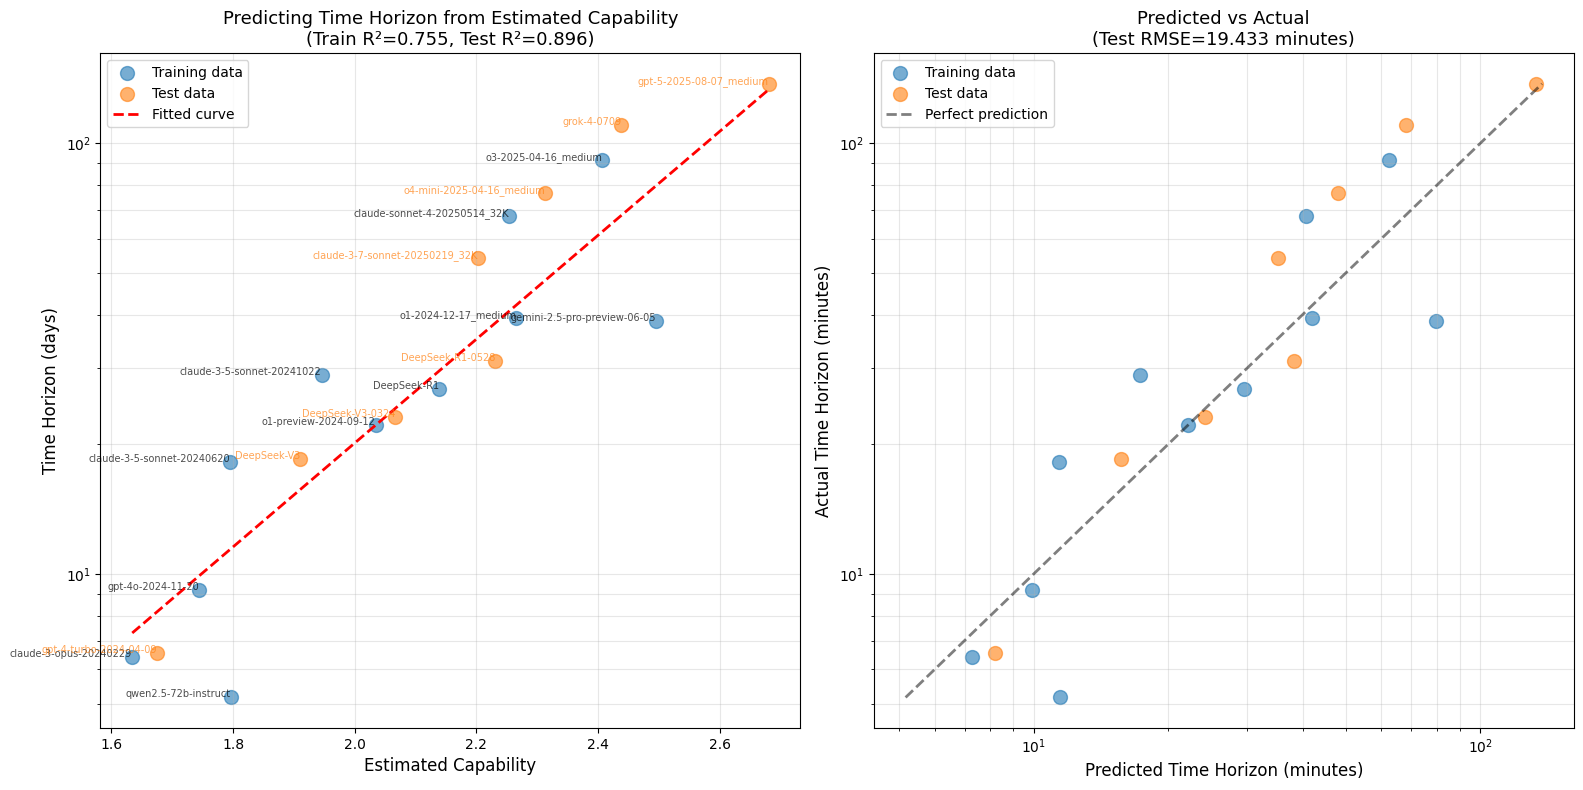


TEST SET PREDICTIONS (Original Scale)
                         model  estimated_capability  time_horizon  predicted_time_horizon     error  abs_error  pct_error
                   grok-4-0709              2.438496    110.075251               67.970982 42.104269  42.104269  38.250441
     o4-mini-2025-04-16_medium              2.313640     76.509015               48.060829 28.448186  28.448186  37.182789
claude-3-7-sonnet-20250219_32K              2.202126     54.226342               35.265190 18.961152  18.961152  34.966680
              DeepSeek-R1-0528              2.231365     31.167847               38.247004 -7.079157   7.079157 -22.713012
       gpt-5-2025-08-07_medium              2.680614    137.318539              133.116151  4.202388   4.202388   3.060321
                   DeepSeek-V3              1.909781     18.472532               15.663280  2.809252   2.809252  15.207724
        gpt-4-turbo-2024-04-09              1.675830      6.567339                8.181281 -1.613942

In [30]:
# Combine df_metr and df_cm1 to predict time_horizon from estimated_capability
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats

# Merge the two dataframes on model
df_combined = df_metr.merge(
    df_cm1[['model', 'estimated_capability']], 
    on='model', 
    how='inner'
)

print(f"Original df_metr rows: {len(df_metr)}")
print(f"Original df_cm1 rows: {len(df_cm1)}")
print(f"Combined df rows (models in both): {len(df_combined)}")
print(f"\nModels in combined dataset:")
print(df_combined[['model', 'time_horizon', 'estimated_capability']])

# Check for missing values
print(f"\nMissing values:")
print(df_combined[['model', 'time_horizon', 'estimated_capability']].isnull().sum())

# Remove any rows with missing values and non-positive time_horizon values
df_combined_clean = df_combined.dropna(subset=['time_horizon', 'estimated_capability'])
df_combined_clean = df_combined_clean[df_combined_clean['time_horizon'] > 0].copy()
print(f"\nRows after removing missing values and non-positive time_horizon: {len(df_combined_clean)}")

# Add log-transformed time_horizon
df_combined_clean['log_time_horizon'] = np.log(df_combined_clean['time_horizon'])
print(f"\nTime horizon statistics:")
print(f"  Original - Min: {df_combined_clean['time_horizon'].min():.2f}, Max: {df_combined_clean['time_horizon'].max():.2f}, Mean: {df_combined_clean['time_horizon'].mean():.2f}")
print(f"  Log-transformed - Min: {df_combined_clean['log_time_horizon'].min():.2f}, Max: {df_combined_clean['log_time_horizon'].max():.2f}, Mean: {df_combined_clean['log_time_horizon'].mean():.2f}")

if len(df_combined_clean) < 5:
    print("\n⚠️ WARNING: Too few data points for meaningful train-test split analysis!")
    print("Consider using leave-one-out cross-validation or all data for fitting.")
else:
    # Train-test split (80/20)
    X = df_combined_clean[['estimated_capability']].values
    y = df_combined_clean['log_time_horizon'].values  # Use log-transformed target
    y_original = df_combined_clean['time_horizon'].values  # Keep original for reference
    
    # Random state for reproducibility
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df_combined_clean.index, test_size=0.4, random_state=42
    )
    
    print(f"\nTrain set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics on training set
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Metrics on test set
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Pearson correlation
    train_corr, train_corr_pval = stats.pearsonr(y_train, y_train_pred)
    test_corr, test_corr_pval = stats.pearsonr(y_test, y_test_pred)
    
    # Calculate metrics on original scale as well
    y_train_original = y_original[idx_train]
    y_test_original = y_original[idx_test]
    y_train_pred_original = np.exp(y_train_pred)
    y_test_pred_original = np.exp(y_test_pred)
    
    train_r2_original = r2_score(y_train_original, y_train_pred_original)
    test_r2_original = r2_score(y_test_original, y_test_pred_original)
    train_rmse_original = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
    test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
    
    print(f"\n" + "="*60)
    print("MODEL PERFORMANCE (Random Split)")
    print("="*60)
    print(f"\nModel equation: log(time_horizon) = {model.coef_[0]:.4f} * estimated_capability + {model.intercept_:.4f}")
    print(f"Or equivalently: time_horizon = exp({model.coef_[0]:.4f} * estimated_capability + {model.intercept_:.4f})")
    
    print(f"\nTraining Set (log scale):")
    print(f"  R²: {train_r2:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE: {train_mae:.4f}")
    print(f"  Pearson r: {train_corr:.4f} (p={train_corr_pval:.4f})")
    
    print(f"\nTest Set (log scale):")
    print(f"  R²: {test_r2:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE: {test_mae:.4f}")
    print(f"  Pearson r: {test_corr:.4f} (p={test_corr_pval:.4f})")
    
    # print(f"\nTraining Set (original scale after back-transform):")
    # print(f"  R²: {train_r2_original:.4f}")
    # print(f"  RMSE: {train_rmse_original:.4f}")
    
    # print(f"\nTest Set (original scale after back-transform):")
    # print(f"  R²: {test_r2_original:.4f}")
    # print(f"  RMSE: {test_rmse_original:.4f}")
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: Scatter plot with fit line (with log scale on y-axis)
    ax1 = axes[0]
    # Plot original time_horizon values (not log-transformed)
    ax1.scatter(X_train, y_train_original, alpha=0.6, s=100, label='Training data', color='tab:blue')
    ax1.scatter(X_test, y_test_original, alpha=0.6, s=100, label='Test data', color='tab:orange')
    
    # Plot regression line (back-transformed to original scale)
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_range_pred = model.predict(X_range)
    y_range_pred_original = np.exp(y_range_pred)
    ax1.plot(X_range, y_range_pred_original, 'r--', linewidth=2, label='Fitted curve')
    
    # Annotate points with model names
    for idx in idx_train:
        ax1.annotate(df_combined_clean.loc[idx, 'model'], 
                    xy=(df_combined_clean.loc[idx, 'estimated_capability'], 
                        df_combined_clean.loc[idx, 'time_horizon']),
                    fontsize=7, alpha=0.7, ha='right')
    
    for idx in idx_test:
        ax1.annotate(df_combined_clean.loc[idx, 'model'], 
                    xy=(df_combined_clean.loc[idx, 'estimated_capability'], 
                        df_combined_clean.loc[idx, 'time_horizon']),
                    fontsize=7, alpha=0.7, ha='right', color='tab:orange')
    
    ax1.set_xlabel('Estimated Capability', fontsize=12)
    ax1.set_ylabel('Time Horizon (days)', fontsize=12)
    ax1.set_yscale('log')  # Set y-axis to logarithmic scale
    ax1.set_title(f'Predicting Time Horizon from Estimated Capability\n(Train R²={train_r2:.3f}, Test R²={test_r2:.3f})', 
                 fontsize=13)
    ax1.legend()
    ax1.grid(True, alpha=0.3, which='both')  # Show grid for both major and minor ticks
    
    # Plot 2: Predicted vs Actual (with log scale on both axes)
    ax2 = axes[1]
    ax2.scatter(y_train_pred_original, y_train_original, alpha=0.6, s=100, label='Training data', color='tab:blue')
    ax2.scatter(y_test_pred_original, y_test_original, alpha=0.6, s=100, label='Test data', color='tab:orange')
    
    # Plot diagonal line (perfect predictions)
    y_min_orig = min(y_original.min(), y_train_pred_original.min(), y_test_pred_original.min())
    y_max_orig = max(y_original.max(), y_train_pred_original.max(), y_test_pred_original.max())
    ax2.plot([y_min_orig, y_max_orig], [y_min_orig, y_max_orig], 'k--', linewidth=2, alpha=0.5, label='Perfect prediction')
    
    ax2.set_xlabel('Predicted Time Horizon (minutes)', fontsize=12)
    ax2.set_ylabel('Actual Time Horizon (minutes)', fontsize=12)
    ax2.set_xscale('log')  # Set x-axis to logarithmic scale
    ax2.set_yscale('log')  # Set y-axis to logarithmic scale
    ax2.set_title(f'Predicted vs Actual\n(Test RMSE={test_rmse_original:.3f} minutes)', fontsize=13)
    ax2.legend()
    ax2.grid(True, alpha=0.3, which='both')  # Show grid for both major and minor ticks
    
    # # Plot 3: Scatter plot with fit line (ORIGINAL SCALE)
    # ax3 = axes[1, 0]
    # ax3.scatter(X_train, y_train_original, alpha=0.6, s=100, label='Training data', color='tab:blue')
    # ax3.scatter(X_test, y_test_original, alpha=0.6, s=100, label='Test data', color='tab:orange')
    
    # # Plot regression line (back-transformed)
    # y_range_pred_original = np.exp(y_range_pred)
    # ax3.plot(X_range, y_range_pred_original, 'r--', linewidth=2, label='Fitted curve')
    
    # # Annotate points with model names
    # for idx in idx_train:
    #     ax3.annotate(df_combined_clean.loc[idx, 'model'], 
    #                 xy=(df_combined_clean.loc[idx, 'estimated_capability'], 
    #                     df_combined_clean.loc[idx, 'time_horizon']),
    #                 fontsize=7, alpha=0.7, ha='right')
    
    # for idx in idx_test:
    #     ax3.annotate(df_combined_clean.loc[idx, 'model'], 
    #                 xy=(df_combined_clean.loc[idx, 'estimated_capability'], 
    #                     df_combined_clean.loc[idx, 'time_horizon']),
    #                 fontsize=7, alpha=0.7, ha='right', color='tab:orange')
    
    # ax3.set_xlabel('Estimated Capability', fontsize=12)
    # ax3.set_ylabel('Time Horizon (Original Scale)', fontsize=12)
    # ax3.set_title(f'Predicting Time Horizon (Original Scale)\n(Train R²={train_r2_original:.3f}, Test R²={test_r2_original:.3f})', 
    #              fontsize=13)
    # ax3.legend()
    # ax3.grid(True, alpha=0.3)
    
    # # Plot 4: Predicted vs Actual (ORIGINAL SCALE)
    # ax4 = axes[1, 1]
    # ax4.scatter(y_train_pred_original, y_train_original, alpha=0.6, s=100, label='Training data', color='tab:blue')
    # ax4.scatter(y_test_pred_original, y_test_original, alpha=0.6, s=100, label='Test data', color='tab:orange')
    
    # # Plot diagonal line (perfect predictions)
    # y_min_orig = min(y_original.min(), y_train_pred_original.min(), y_test_pred_original.min())
    # y_max_orig = max(y_original.max(), y_train_pred_original.max(), y_test_pred_original.max())
    # ax4.plot([y_min_orig, y_max_orig], [y_min_orig, y_max_orig], 'k--', linewidth=2, alpha=0.5, label='Perfect prediction')
    
    # ax4.set_xlabel('Predicted Time Horizon', fontsize=12)
    # ax4.set_ylabel('Actual Time Horizon', fontsize=12)
    # ax4.set_title(f'Predicted vs Actual (Original Scale)\n(Test RMSE={test_rmse_original:.3f})', fontsize=13)
    # ax4.legend()
    # ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("outputs/notebooks/predicting_time_horizon_from_capability.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print test set predictions vs actuals
    print(f"\n" + "="*60)
    print("TEST SET PREDICTIONS (Original Scale)")
    print("="*60)
    test_results = df_combined_clean.loc[idx_test, ['model', 'estimated_capability', 'time_horizon']].copy()
    test_results['predicted_time_horizon'] = y_test_pred_original
    test_results['error'] = y_test_original - y_test_pred_original
    test_results['abs_error'] = np.abs(test_results['error'])
    test_results['pct_error'] = 100 * test_results['error'] / y_test_original
    test_results = test_results.sort_values('abs_error', ascending=False)
    
    print(test_results.to_string(index=False))


In [37]:
# ============================================================================
# BENCHMARK-BASED ANALYSIS: Predict time_horizon from benchmark performance
# ============================================================================
# TO ANALYZE A DIFFERENT BENCHMARK: Simply change BENCHMARK_NAME below!
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats

# ============================================================================
# BENCHMARK CONFIGURATION - Change this to analyze different benchmarks!
# ============================================================================
# Examples: "GPQA diamond", "MMLU", "BBH", "HellaSwag", "MATH level 5", 
#           "FrontierMath-2025-02-28-Private", "ARC AI2", etc.
# To see all available: print(sorted(df1['benchmark'].unique()))

BENCHMARK_NAME = 'GPQA diamond'  # ← CHANGE THIS to analyze different benchmarks

# ============================================================================

# Filter for specified benchmark
df_benchmark = df1[df1['benchmark'] == BENCHMARK_NAME].copy()
print(f"'{BENCHMARK_NAME}' benchmark has {len(df_benchmark)} model evaluations")

if len(df_benchmark) == 0:
    print(f"\n⚠️ ERROR: No data found for benchmark '{BENCHMARK_NAME}'")
    print("\nAvailable benchmarks:")
    for bench in sorted(df1['benchmark'].unique()):
        print(f"  - {bench}")

# Apply inverse sigmoid (logit) transformation to performance
# logit(p) = log(p / (1-p))
# Clip performance to avoid log(0) or log(inf)
epsilon = 1e-6
df_benchmark['performance_clipped'] = df_benchmark['performance'].clip(epsilon, 1 - epsilon)
df_benchmark['logit_performance'] = np.log(df_benchmark['performance_clipped'] / (1 - df_benchmark['performance_clipped']))

print(f"\n{BENCHMARK_NAME} Performance statistics:")
print(f"  Original - Min: {df_benchmark['performance'].min():.4f}, Max: {df_benchmark['performance'].max():.4f}, Mean: {df_benchmark['performance'].mean():.4f}")
print(f"  Logit-transformed - Min: {df_benchmark['logit_performance'].min():.4f}, Max: {df_benchmark['logit_performance'].max():.4f}, Mean: {df_benchmark['logit_performance'].mean():.4f}")

# Merge with METR time_horizon data
df_benchmark_metr = df_benchmark.merge(
    df_metr[['model', 'time_horizon']], 
    on='model', 
    how='inner'
)

# Also merge with model dates for temporal split
df_benchmark_metr = df_benchmark_metr.merge(
    df_cm1[['model', 'date', 'date_obj']],
    on='model',
    how='inner'
)

print(f"\nModels with both {BENCHMARK_NAME} performance and METR time_horizon: {len(df_benchmark_metr)}")
print(f"\nModels in combined {BENCHMARK_NAME}-METR dataset:")
print(df_benchmark_metr[['model', 'performance', 'logit_performance', 'time_horizon']].to_string(index=False))


'GPQA diamond' benchmark has 88 model evaluations

GPQA diamond Performance statistics:
  Original - Min: 0.1470, Max: 0.8700, Mean: 0.5888
  Logit-transformed - Min: -1.7583, Max: 1.9010, Mean: 0.4008

Models with both GPQA diamond performance and METR time_horizon: 17

Models in combined GPQA diamond-METR dataset:
                         model  performance  logit_performance  time_horizon
                   grok-4-0709        0.870           1.900959    110.075251
    claude-3-5-sonnet-20240620        0.540           0.160343     18.216830
          qwen2.5-72b-instruct        0.491          -0.036004      5.165813
          o1-2024-12-17_medium        0.758           1.141746     39.206576
                   DeepSeek-V3        0.565           0.261480     18.472532
             gpt-4o-2024-11-20        0.479          -0.084049      9.170450
        claude-3-opus-20240229        0.472          -0.112117      6.422825
        gpt-4-turbo-2024-04-09        0.466          -0.136210    


Rows after removing missing values and non-positive time_horizon: 17

Train set size: 10
Test set size: 7

GPQA DIAMOND RANDOM SPLIT MODEL PERFORMANCE

Model equation: log(time_horizon) = 1.1088 * logit(GPQA diamond_perf) + 2.3678
Or equivalently: time_horizon = exp(1.1088 * logit(GPQA diamond_perf) + 2.3678)

Training Set (log scale):
  R²: 0.6082
  RMSE: 0.4429
  MAE: 0.3553
  Pearson r: 0.7799 (p=0.0078)

Test Set (log scale):
  R²: 0.7887
  RMSE: 0.4118
  MAE: 0.3681
  Pearson r: 0.9093 (p=0.0045)


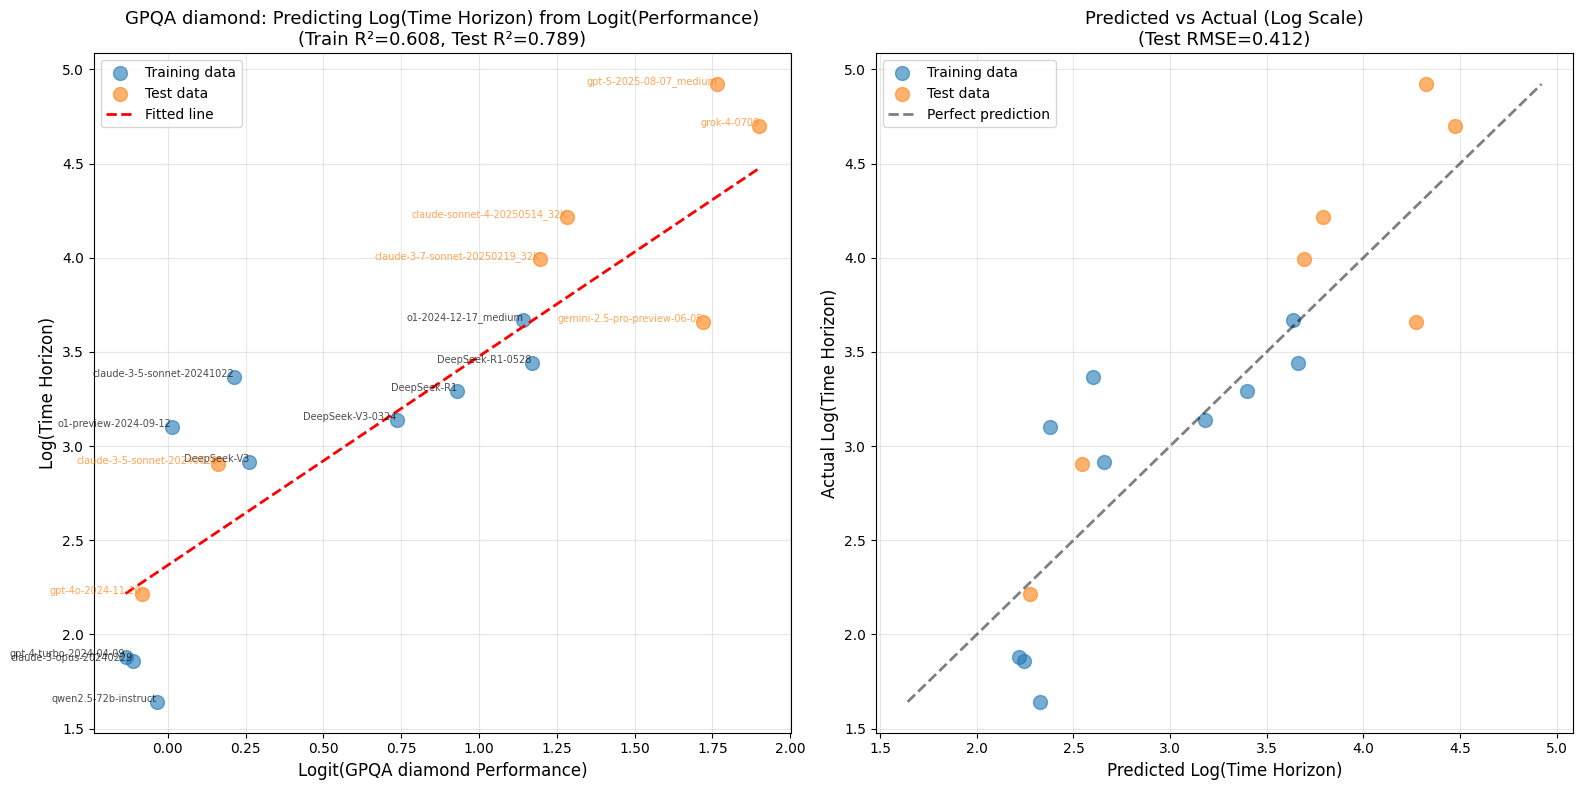


TEST SET PREDICTIONS (Original Scale)
                         model  performance  logit_performance  time_horizon  predicted_time_horizon      error  abs_error  pct_error
       gpt-5-2025-08-07_medium        0.854           1.766325    137.318539               75.660814  61.657725  61.657725  44.901239
  gemini-2.5-pro-preview-06-05        0.848           1.719000     38.734274               71.793030 -33.058756  33.058756 -85.347555
  claude-sonnet-4-20250514_32K        0.783           1.283235     67.705892               44.283621  23.422271  23.422271  34.594140
                   grok-4-0709        0.870           1.900959    110.075251               87.842171  22.233080  22.233080  20.198074
claude-3-7-sonnet-20250219_32K        0.768           1.197052     54.226342               40.247821  13.978521  13.978521  25.778100
    claude-3-5-sonnet-20240620        0.540           0.160343     18.216830               12.750371   5.466459   5.466459  30.007738
             gpt-4o-202

In [38]:
# BENCHMARK RANDOM SPLIT: Predict log(time_horizon) from logit(benchmark performance)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats

# Remove rows with missing values and non-positive time_horizon values
df_benchmark_clean = df_benchmark_metr.dropna(subset=['time_horizon', 'logit_performance'])
df_benchmark_clean = df_benchmark_clean[df_benchmark_clean['time_horizon'] > 0].copy()
print(f"\nRows after removing missing values and non-positive time_horizon: {len(df_benchmark_clean)}")

# Add log-transformed time_horizon
df_benchmark_clean['log_time_horizon'] = np.log(df_benchmark_clean['time_horizon'])

if len(df_benchmark_clean) < 5:
    print("\n⚠️ WARNING: Too few data points for meaningful train-test split analysis!")
else:
    # Train-test split (80/20)
    X = df_benchmark_clean[['logit_performance']].values
    y = df_benchmark_clean['log_time_horizon'].values  # Use log-transformed target
    y_original = df_benchmark_clean['time_horizon'].values  # Keep original for reference
    
    # Random state for reproducibility
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df_benchmark_clean.index, test_size=0.4, random_state=42
    )
    
    print(f"\nTrain set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    
    # Fit linear regression model
    model_gpqa = LinearRegression()
    model_gpqa.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model_gpqa.predict(X_train)
    y_test_pred = model_gpqa.predict(X_test)
    
    # Metrics on log scale
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Pearson correlation
    train_corr, train_corr_pval = stats.pearsonr(y_train, y_train_pred)
    test_corr, test_corr_pval = stats.pearsonr(y_test, y_test_pred)
    
    # Calculate metrics on original scale as well
    y_train_original = y_original[idx_train]
    y_test_original = y_original[idx_test]
    y_train_pred_original = np.exp(y_train_pred)
    y_test_pred_original = np.exp(y_test_pred)
    
    train_r2_original = r2_score(y_train_original, y_train_pred_original)
    test_r2_original = r2_score(y_test_original, y_test_pred_original)
    train_rmse_original = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
    test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
    
    print(f"\n" + "="*60)
    print(f"{BENCHMARK_NAME.upper()} RANDOM SPLIT MODEL PERFORMANCE")
    print("="*60)
    print(f"\nModel equation: log(time_horizon) = {model_gpqa.coef_[0]:.4f} * logit({BENCHMARK_NAME}_perf) + {model_gpqa.intercept_:.4f}")
    print(f"Or equivalently: time_horizon = exp({model_gpqa.coef_[0]:.4f} * logit({BENCHMARK_NAME}_perf) + {model_gpqa.intercept_:.4f})")
    
    print(f"\nTraining Set (log scale):")
    print(f"  R²: {train_r2:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE: {train_mae:.4f}")
    print(f"  Pearson r: {train_corr:.4f} (p={train_corr_pval:.4f})")
    
    print(f"\nTest Set (log scale):")
    print(f"  R²: {test_r2:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE: {test_mae:.4f}")
    print(f"  Pearson r: {test_corr:.4f} (p={test_corr_pval:.4f})")
    
    # print(f"\nTraining Set (original scale after back-transform):")
    # print(f"  R²: {train_r2_original:.4f}")
    # print(f"  RMSE: {train_rmse_original:.4f}")
    
    # print(f"\nTest Set (original scale after back-transform):")
    # print(f"  R²: {test_r2_original:.4f}")
    # print(f"  RMSE: {test_rmse_original:.4f}")
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: Scatter plot with fit line (LOG SCALE)
    ax1 = axes[0]
    ax1.scatter(X_train, y_train, alpha=0.6, s=100, label='Training data', color='tab:blue')
    ax1.scatter(X_test, y_test, alpha=0.6, s=100, label='Test data', color='tab:orange')
    
    # Plot regression line
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_range_pred = model_gpqa.predict(X_range)
    ax1.plot(X_range, y_range_pred, 'r--', linewidth=2, label='Fitted line')
    
    # Annotate points with model names
    for idx in idx_train:
        ax1.annotate(df_benchmark_clean.loc[idx, 'model'], 
                    xy=(df_benchmark_clean.loc[idx, 'logit_performance'], 
                        df_benchmark_clean.loc[idx, 'log_time_horizon']),
                    fontsize=7, alpha=0.7, ha='right')
    
    for idx in idx_test:
        ax1.annotate(df_benchmark_clean.loc[idx, 'model'], 
                    xy=(df_benchmark_clean.loc[idx, 'logit_performance'], 
                        df_benchmark_clean.loc[idx, 'log_time_horizon']),
                    fontsize=7, alpha=0.7, ha='right', color='tab:orange')
    
    ax1.set_xlabel(f'Logit({BENCHMARK_NAME} Performance)', fontsize=12)
    ax1.set_ylabel('Log(Time Horizon)', fontsize=12)
    ax1.set_title(f'{BENCHMARK_NAME}: Predicting Log(Time Horizon) from Logit(Performance)\n(Train R²={train_r2:.3f}, Test R²={test_r2:.3f})', 
                 fontsize=13)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Predicted vs Actual (LOG SCALE)
    ax2 = axes[1]
    ax2.scatter(y_train_pred, y_train, alpha=0.6, s=100, label='Training data', color='tab:blue')
    ax2.scatter(y_test_pred, y_test, alpha=0.6, s=100, label='Test data', color='tab:orange')
    
    # Plot diagonal line (perfect predictions)
    y_min = min(y.min(), y_train_pred.min(), y_test_pred.min())
    y_max = max(y.max(), y_train_pred.max(), y_test_pred.max())
    ax2.plot([y_min, y_max], [y_min, y_max], 'k--', linewidth=2, alpha=0.5, label='Perfect prediction')
    
    ax2.set_xlabel('Predicted Log(Time Horizon)', fontsize=12)
    ax2.set_ylabel('Actual Log(Time Horizon)', fontsize=12)
    ax2.set_title(f'Predicted vs Actual (Log Scale)\n(Test RMSE={test_rmse:.3f})', fontsize=13)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # # Plot 3: Scatter plot with fit line (ORIGINAL SCALE)
    # ax3 = axes[1, 0]
    # ax3.scatter(X_train, y_train_original, alpha=0.6, s=100, label='Training data', color='tab:blue')
    # ax3.scatter(X_test, y_test_original, alpha=0.6, s=100, label='Test data', color='tab:orange')
    
    # # Plot regression line (back-transformed)
    # y_range_pred_original = np.exp(y_range_pred)
    # ax3.plot(X_range, y_range_pred_original, 'r--', linewidth=2, label='Fitted curve')
    
    # # Annotate points with model names
    # for idx in idx_train:
    #     ax3.annotate(df_benchmark_clean.loc[idx, 'model'], 
    #                 xy=(df_benchmark_clean.loc[idx, 'logit_performance'], 
    #                     df_benchmark_clean.loc[idx, 'time_horizon']),
    #                 fontsize=7, alpha=0.7, ha='right')
    
    # for idx in idx_test:
    #     ax3.annotate(df_benchmark_clean.loc[idx, 'model'], 
    #                 xy=(df_benchmark_clean.loc[idx, 'logit_performance'], 
    #                     df_benchmark_clean.loc[idx, 'time_horizon']),
    #                 fontsize=7, alpha=0.7, ha='right', color='tab:orange')
    
    # ax3.set_xlabel(f'Logit({BENCHMARK_NAME} Performance)', fontsize=12)
    # ax3.set_ylabel('Time Horizon (Original Scale)', fontsize=12)
    # ax3.set_title(f'{BENCHMARK_NAME}: Predicting Time Horizon (Original Scale)\n(Train R²={train_r2_original:.3f}, Test R²={test_r2_original:.3f})', 
    #              fontsize=13)
    # ax3.legend()
    # ax3.grid(True, alpha=0.3)
    
    # # Plot 4: Predicted vs Actual (ORIGINAL SCALE)
    # ax4 = axes[1, 1]
    # ax4.scatter(y_train_pred_original, y_train_original, alpha=0.6, s=100, label='Training data', color='tab:blue')
    # ax4.scatter(y_test_pred_original, y_test_original, alpha=0.6, s=100, label='Test data', color='tab:orange')
    
    # # Plot diagonal line (perfect predictions)
    # y_min_orig = min(y_original.min(), y_train_pred_original.min(), y_test_pred_original.min())
    # y_max_orig = max(y_original.max(), y_train_pred_original.max(), y_test_pred_original.max())
    # ax4.plot([y_min_orig, y_max_orig], [y_min_orig, y_max_orig], 'k--', linewidth=2, alpha=0.5, label='Perfect prediction')
    
    # ax4.set_xlabel('Predicted Time Horizon', fontsize=12)
    # ax4.set_ylabel('Actual Time Horizon', fontsize=12)
    # ax4.set_title(f'Predicted vs Actual (Original Scale)\n(Test RMSE={test_rmse_original:.3f})', fontsize=13)
    # ax4.legend()
    # ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("outputs/notebooks/predicting_time_horizon_from_benchmark_performance.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print test set predictions vs actuals
    print(f"\n" + "="*60)
    print("TEST SET PREDICTIONS (Original Scale)")
    print("="*60)
    test_results = df_benchmark_clean.loc[idx_test, ['model', 'performance', 'logit_performance', 'time_horizon']].copy()
    test_results['predicted_time_horizon'] = y_test_pred_original
    test_results['error'] = y_test_original - y_test_pred_original
    test_results['abs_error'] = np.abs(test_results['error'])
    test_results['pct_error'] = 100 * test_results['error'] / y_test_original
    test_results = test_results.sort_values('abs_error', ascending=False)
    
    print(test_results.to_string(index=False))


# Additional results

Line of best fit slope: 0.6728 capability units/year
R-squared: 0.7628


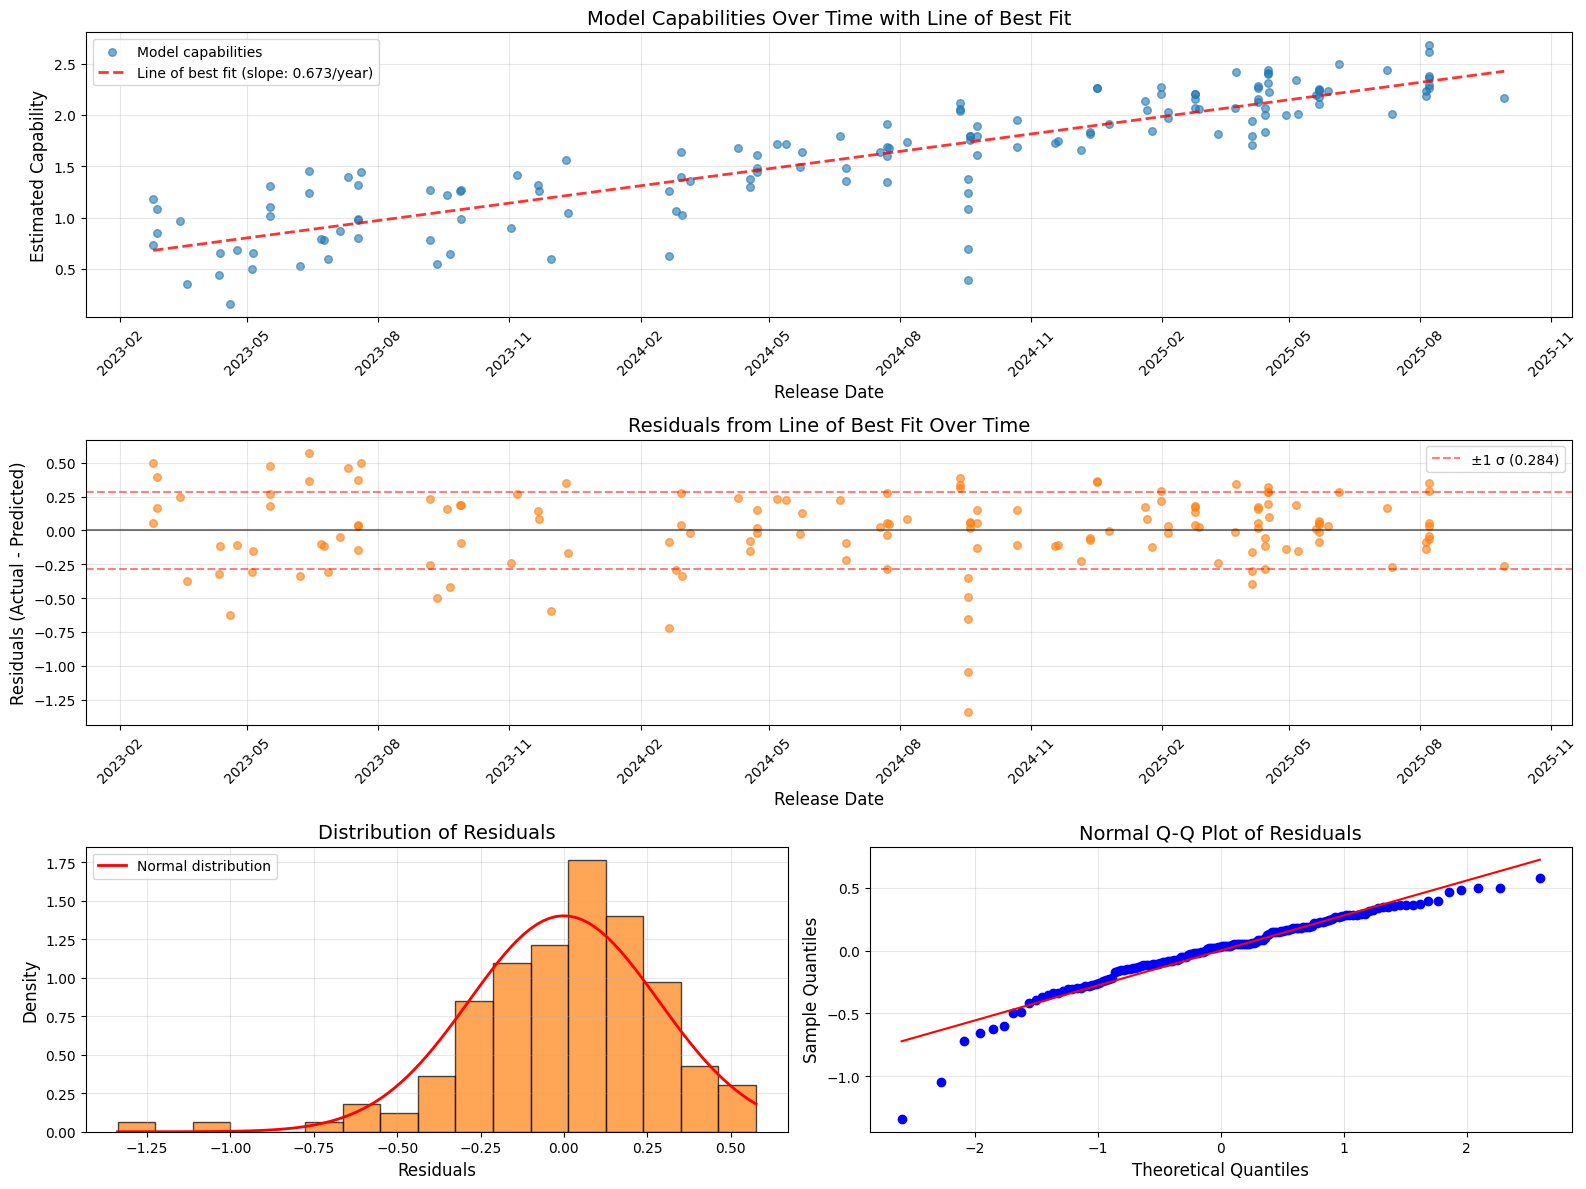


NORMALITY TESTS FOR RESIDUALS

Basic Statistics:
  Mean: -0.000000
  Standard Deviation: 0.2852
  Skewness: -1.1849
  Kurtosis: 3.3713
  Min: -1.3386
  Max: 0.5759
  Sample size: 146

Kolmogorov-Smirnov Test:
  Test statistic: 0.0915
  P-value: 0.1630
  Interpretation: FAIL TO REJECT null hypothesis of normality (α=0.05)

Shapiro-Wilk Test:
  Test statistic: 0.9366
  P-value: 0.0000
  Interpretation: REJECT null hypothesis of normality (α=0.05)

Anderson-Darling Test:
  Test statistic: 1.3999
  Critical values: [0.561 0.639 0.767 0.895 1.064]
  Significance levels: [15.  10.   5.   2.5  1. ]%
  Interpretation: REJECT null hypothesis of normality (α=0.05)

Jarque-Bera Test:
  Test statistic: 103.3075
  P-value: 0.0000
  Interpretation: REJECT null hypothesis of normality (α=0.05)

SUMMARY FOR SYNTHETIC DATA GENERATION

Normality test summary: 3/4 tests reject normality
Recommendation: ✗ GAUSSIAN NOISE assumption is NOT SUPPORTED - consider alternative noise distributions

Additional co

In [ ]:
# Residuals analysis with normality testing for synthetic data generation
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import scipy.stats as stats

# Prepare data for residuals analysis
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df = cap_df.dropna(subset=['date_obj', 'estimated_capability']).sort_values('date_obj').reset_index(drop=True)

# Convert dates to numerical format for regression
X = (cap_df['date_obj'] - cap_df['date_obj'].min()).dt.days.values.reshape(-1, 1)
y = cap_df['estimated_capability'].values

# Fit linear regression (line of best fit)
lr = LinearRegression()
lr.fit(X, y)

# Calculate predicted values and residuals
y_pred = lr.predict(X)
residuals = y - y_pred

# Convert slope to per-year rate
slope_per_year = lr.coef_[0] * 365.25
r2 = lr.score(X, y)

print(f"Line of best fit slope: {slope_per_year:.4f} capability units/year")
print(f"R-squared: {r2:.4f}")

# Create comprehensive residuals analysis plot
fig = plt.figure(figsize=(16, 12))

# 1. Time series plot with line of best fit
ax1 = plt.subplot(3, 2, (1, 2))
ax1.scatter(cap_df['date_obj'], cap_df['estimated_capability'], alpha=0.6, s=30, color='tab:blue', label='Model capabilities')
ax1.plot(cap_df['date_obj'], y_pred, 'r--', alpha=0.8, linewidth=2, label=f'Line of best fit (slope: {slope_per_year:.3f}/year)')
ax1.set_xlabel('Release Date', fontsize=12)
ax1.set_ylabel('Estimated Capability', fontsize=12)
ax1.set_title('Model Capabilities Over Time with Line of Best Fit', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Residuals over time
ax2 = plt.subplot(3, 2, (3, 4))
ax2.scatter(cap_df['date_obj'], residuals, alpha=0.6, s=30, color='tab:orange')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
std_residuals = np.std(residuals)
ax2.axhline(y=std_residuals, color='red', linestyle='--', alpha=0.5, label=f'±1 σ ({std_residuals:.3f})')
ax2.axhline(y=-std_residuals, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Release Date', fontsize=12)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax2.set_title('Residuals from Line of Best Fit Over Time', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 3. Histogram of residuals with normal overlay
ax3 = plt.subplot(3, 2, 5)
n_bins = int(np.sqrt(len(residuals))) + 5  # Sturges' rule with buffer
counts, bins, patches = ax3.hist(residuals, bins=n_bins, density=True, alpha=0.7, color='tab:orange', edgecolor='black')

# Overlay normal distribution
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
normal_overlay = stats.norm.pdf(x_norm, np.mean(residuals), np.std(residuals))
ax3.plot(x_norm, normal_overlay, 'r-', linewidth=2, label='Normal distribution')
ax3.set_xlabel('Residuals', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('Distribution of Residuals', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4. Q-Q plot
ax4 = plt.subplot(3, 2, 6)
stats.probplot(residuals, dist="norm", plot=ax4)
ax4.set_xlabel('Theoretical Quantiles', fontsize=12)
ax4.set_ylabel('Sample Quantiles', fontsize=12)
ax4.set_title('Normal Q-Q Plot of Residuals', fontsize=14)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/notebooks/model_capabilities_residuals_normality_analysis.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Statistical tests for normality
print(f"\n" + "="*60)
print("NORMALITY TESTS FOR RESIDUALS")
print("="*60)

# Basic statistics
print(f"\nBasic Statistics:")
print(f"  Mean: {np.mean(residuals):.6f}")
print(f"  Standard Deviation: {np.std(residuals, ddof=1):.4f}")
print(f"  Skewness: {stats.skew(residuals):.4f}")
print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")
print(f"  Min: {np.min(residuals):.4f}")
print(f"  Max: {np.max(residuals):.4f}")
print(f"  Sample size: {len(residuals)}")

# Kolmogorov-Smirnov test
ks_stat, ks_pvalue = stats.kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
print(f"\nKolmogorov-Smirnov Test:")
print(f"  Test statistic: {ks_stat:.4f}")
print(f"  P-value: {ks_pvalue:.4f}")
print(f"  Interpretation: {'REJECT' if ks_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

# Shapiro-Wilk test (more powerful for small to moderate sample sizes)
if len(residuals) <= 5000:  # Shapiro-Wilk works best for n <= 5000
    sw_stat, sw_pvalue = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk Test:")
    print(f"  Test statistic: {sw_stat:.4f}")
    print(f"  P-value: {sw_pvalue:.4f}")
    print(f"  Interpretation: {'REJECT' if sw_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

# Anderson-Darling test
ad_stat, ad_critical_vals, ad_significance_levels = stats.anderson(residuals, dist='norm')
print(f"\nAnderson-Darling Test:")
print(f"  Test statistic: {ad_stat:.4f}")
print(f"  Critical values: {ad_critical_vals}")
print(f"  Significance levels: {ad_significance_levels}%")
# Find the appropriate critical value for 5% significance
ad_5pct_critical = ad_critical_vals[np.where(ad_significance_levels == 5)[0][0]] if 5 in ad_significance_levels else ad_critical_vals[2]
print(f"  Interpretation: {'REJECT' if ad_stat > ad_5pct_critical else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

# Jarque-Bera test
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print(f"\nJarque-Bera Test:")
print(f"  Test statistic: {jb_stat:.4f}")
print(f"  P-value: {jb_pvalue:.4f}")
print(f"  Interpretation: {'REJECT' if jb_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

print(f"\n" + "="*60)
print("SUMMARY FOR SYNTHETIC DATA GENERATION")
print("="*60)

# Count how many tests reject normality
tests_results = [
    ("Kolmogorov-Smirnov", ks_pvalue < 0.05),
    ("Jarque-Bera", jb_pvalue < 0.05),
    ("Anderson-Darling", ad_stat > ad_5pct_critical)
]

if len(residuals) <= 5000:
    tests_results.append(("Shapiro-Wilk", sw_pvalue < 0.05))

rejections = sum([result[1] for result in tests_results])
total_tests = len(tests_results)

print(f"\nNormality test summary: {rejections}/{total_tests} tests reject normality")
if rejections == 0:
    recommendation = "✓ GAUSSIAN NOISE assumption appears REASONABLE for synthetic data"
elif rejections <= total_tests // 2:
    recommendation = "⚠ GAUSSIAN NOISE assumption is QUESTIONABLE - consider checking sample size or alternative distributions"
else:
    recommendation = "✗ GAUSSIAN NOISE assumption is NOT SUPPORTED - consider alternative noise distributions"

print(f"Recommendation: {recommendation}")

# Additional diagnostics
print(f"\nAdditional considerations:")
if abs(stats.skew(residuals)) > 0.5:
    print(f"  • Residuals show notable skewness ({stats.skew(residuals):.3f})")
if abs(stats.kurtosis(residuals)) > 1.0:
    print(f"  • Residuals show notable kurtosis ({stats.kurtosis(residuals):.3f})")
if len(residuals) < 30:
    print(f"  • Small sample size (n={len(residuals)}) - normality tests have limited power")

print(f"\nFor synthetic data generation:")
print(f"  • Estimated noise std: {np.std(residuals, ddof=1):.4f}")
print(f"  • Suggested distribution: {'Normal(0, {:.4f})'.format(np.std(residuals, ddof=1)) if rejections == 0 else 'Consider empirical distribution or robust alternatives'}")

# Show models with extreme residuals
print(f"\nModels with largest absolute residuals (potential outliers):")
abs_residuals_idx = np.argsort(np.abs(residuals))[-5:]
for idx in abs_residuals_idx[::-1]:
    model_name = cap_df.iloc[idx]['model']
    residual_val = residuals[idx]
    print(f"  {model_name}: {residual_val:.4f}")

Testing different loss increase thresholds...

Threshold: 1.0%

Threshold: 2.5%

Threshold: 5.0%

Threshold: 10.0%

Threshold: 15.0%


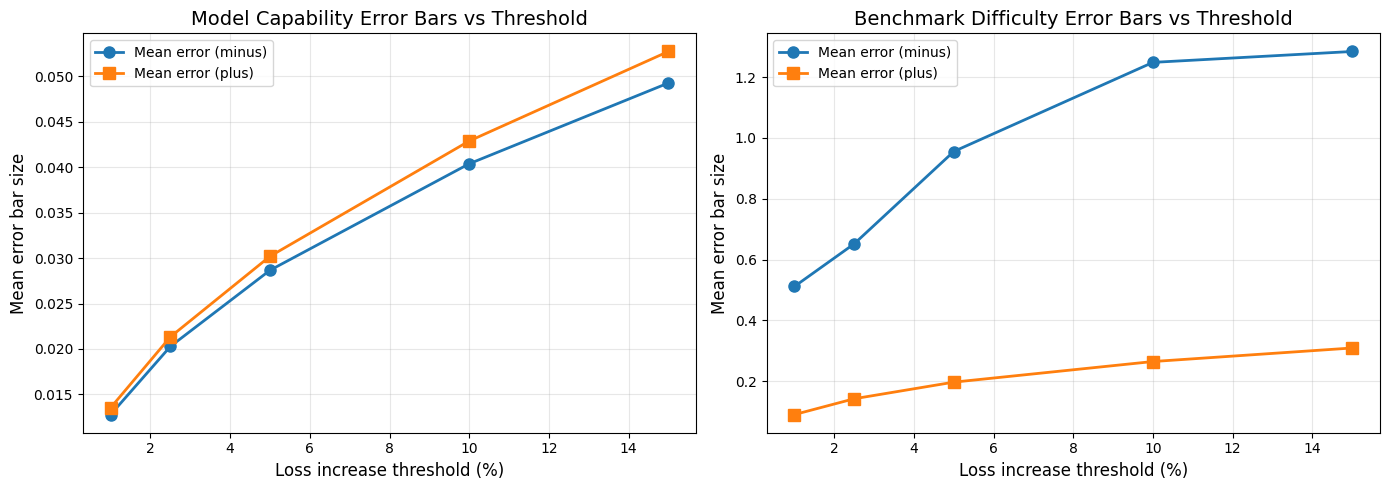


THRESHOLD SENSITIVITY ANALYSIS

As the threshold increases, error bars get larger (we allow more deviation)
The 5% threshold (0.05) is a reasonable default, but you can adjust it based on
how conservative you want your uncertainty estimates to be.


In [ ]:
# ── SENSITIVITY ANALYSIS: Different Threshold Values ──────────────────────

# Test different thresholds
thresholds = [0.01, 0.025, 0.05, 0.10, 0.15]
threshold_results_cap = []
threshold_results_bench = []

print("Testing different loss increase thresholds...")
for threshold in thresholds:
    print(f"\nThreshold: {threshold*100}%")
    
    # Compute error bars with this threshold (only for a subset to save time)
    # Let's just compute for a few models and benchmarks to demonstrate
    cap_errors_sample = compute_capability_error_bars(
        df1, df_cm1.head(10), df_db1, loss_increase_threshold=threshold
    )
    
    bench_errors_sample = compute_difficulty_error_bars(
        df1, df_cm1, df_db1.head(10), loss_increase_threshold=threshold
    )
    
    threshold_results_cap.append({
        'threshold': threshold,
        'mean_error_minus': cap_errors_sample['error_minus'].mean(),
        'mean_error_plus': cap_errors_sample['error_plus'].mean()
    })
    
    threshold_results_bench.append({
        'threshold': threshold,
        'mean_error_minus': bench_errors_sample['error_minus'].mean(),
        'mean_error_plus': bench_errors_sample['error_plus'].mean()
    })

# Plot how error bars change with threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Capabilities
df_thresh_cap = pd.DataFrame(threshold_results_cap)
ax1.plot(df_thresh_cap['threshold'] * 100, df_thresh_cap['mean_error_minus'], 
         'o-', label='Mean error (minus)', linewidth=2, markersize=8)
ax1.plot(df_thresh_cap['threshold'] * 100, df_thresh_cap['mean_error_plus'], 
         's-', label='Mean error (plus)', linewidth=2, markersize=8)
ax1.set_xlabel('Loss increase threshold (%)', fontsize=12)
ax1.set_ylabel('Mean error bar size', fontsize=12)
ax1.set_title('Model Capability Error Bars vs Threshold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Benchmarks
df_thresh_bench = pd.DataFrame(threshold_results_bench)
ax2.plot(df_thresh_bench['threshold'] * 100, df_thresh_bench['mean_error_minus'], 
         'o-', label='Mean error (minus)', linewidth=2, markersize=8)
ax2.plot(df_thresh_bench['threshold'] * 100, df_thresh_bench['mean_error_plus'], 
         's-', label='Mean error (plus)', linewidth=2, markersize=8)
ax2.set_xlabel('Loss increase threshold (%)', fontsize=12)
ax2.set_ylabel('Mean error bar size', fontsize=12)
ax2.set_title('Benchmark Difficulty Error Bars vs Threshold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/notebooks/threshold_sensitivity_analysis.pdf", dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("="*60)
print("\nAs the threshold increases, error bars get larger (we allow more deviation)")
print("The 5% threshold (0.05) is a reasonable default, but you can adjust it based on")
print("how conservative you want your uncertainty estimates to be.")


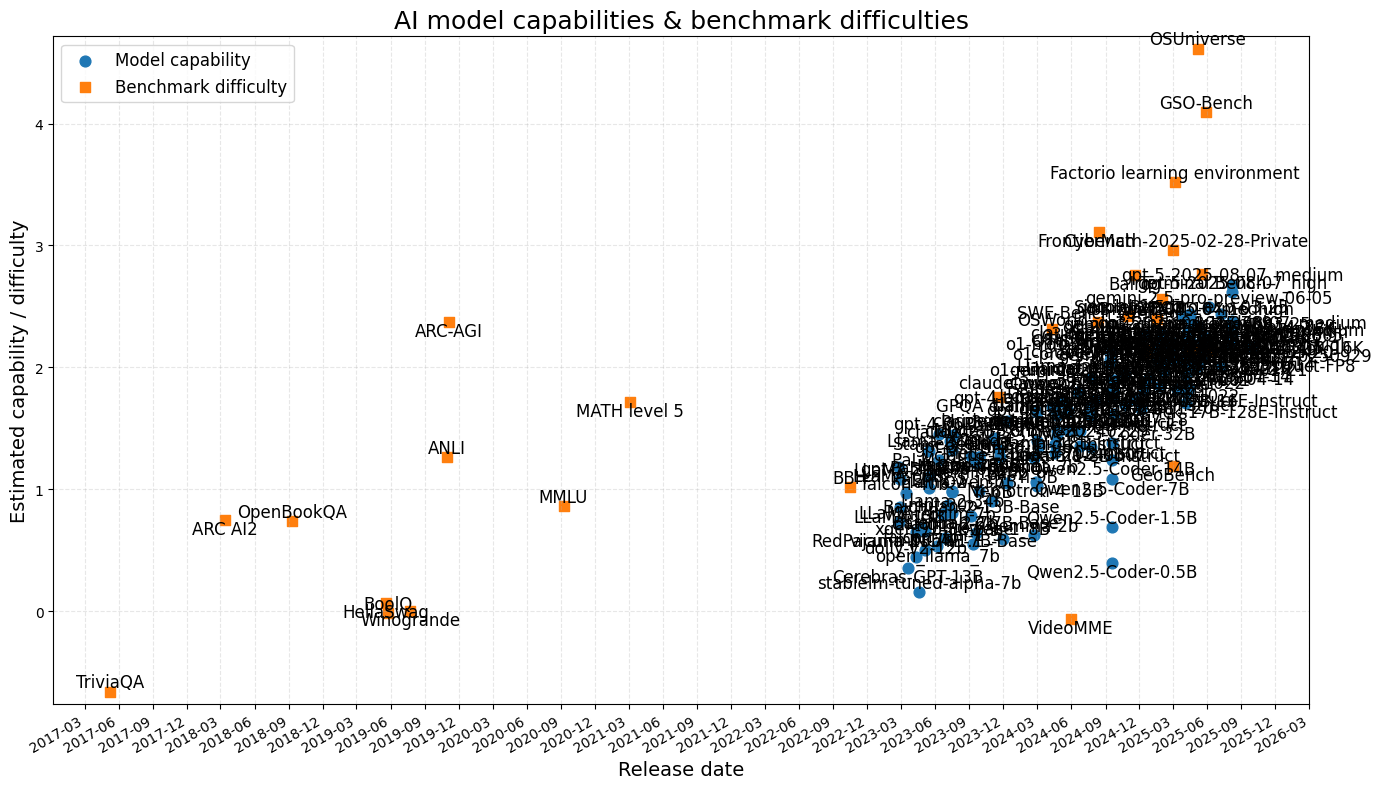

In [ ]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_db1.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
bench_plot = ax.scatter(bench_dates_num, bench_values,
                        marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    # if name not in annotate_models:
    #     continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df["benchmark_name"])):
    # if name not in annotate_benchmarks:
    #     continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(),  bench_values.min()) - 0.1
max_y = max(cap_values.max(),  bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
# ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("outputs/notebooks/capabilities_and_benchmarks_over_time_all_annotated.pdf", dpi=300, bbox_inches='tight')
plt.show()


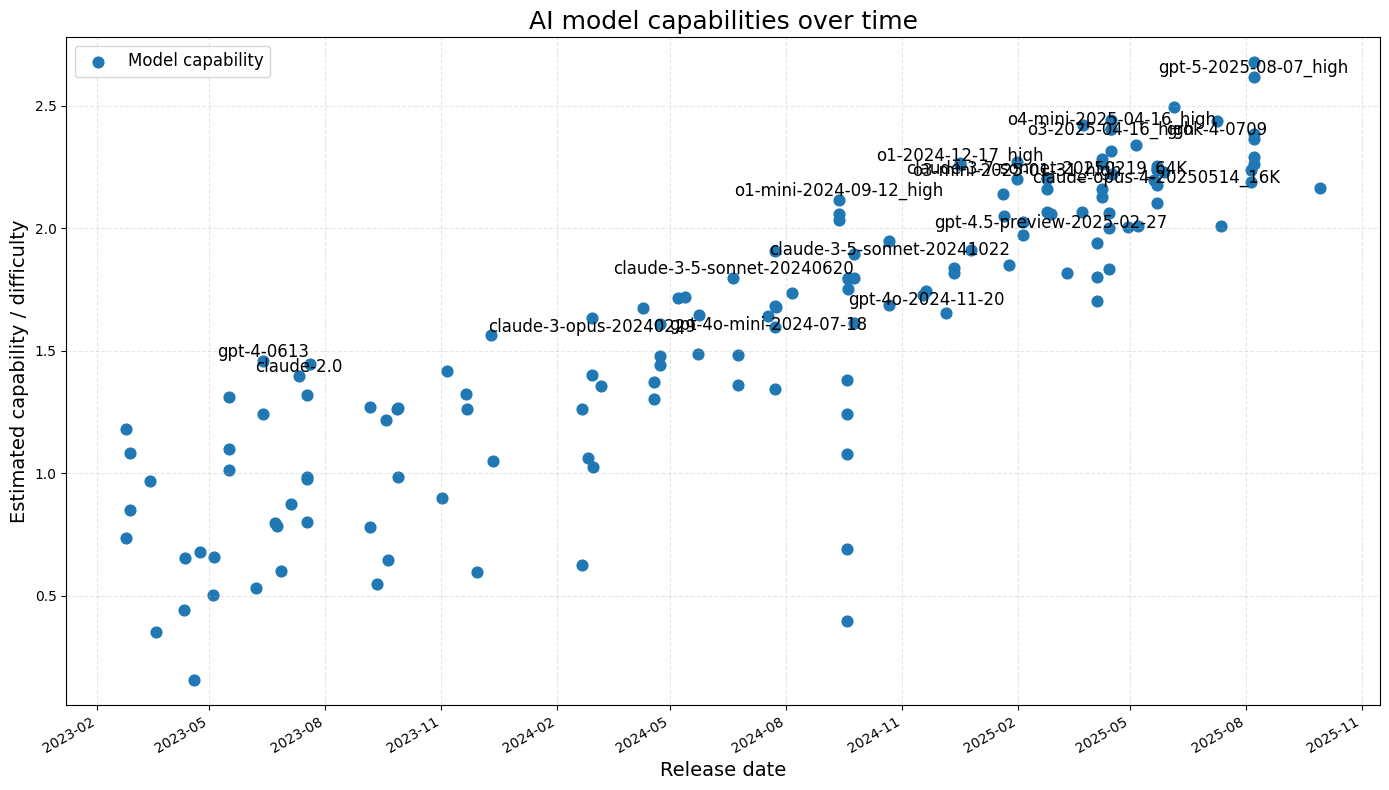

In [ ]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_db1.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
# bench_plot = ax.scatter(bench_dates_num, bench_values,
#                         marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in ref_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities over time", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = cap_values.min() - 0.1
max_y = cap_values.max() + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
# ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("outputs/notebooks/capabilities_over_time.pdf", dpi=300, bbox_inches='tight')
plt.show()


Bootstrapped mean rate: 0.6730 capability units/year
95% confidence interval: [0.6144, 0.7322]


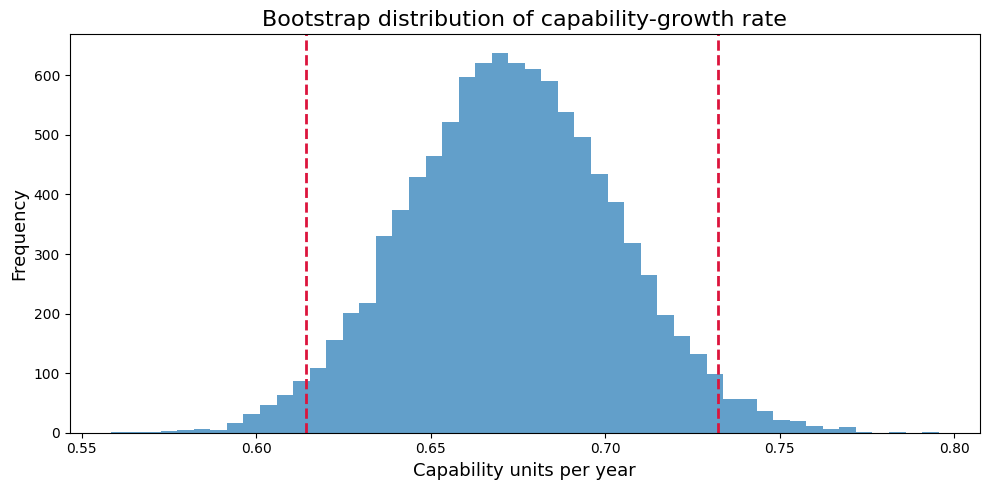

In [ ]:
n_boot      = 10000          # number of bootstrap resamples
rng         = np.random.default_rng(0)   # reproducible seed

# x_full = cap_dates_num                       # days-since-0000-12-31 (float64)
# y_full = cap_values.to_numpy()         # capability values (float64)

mask = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
x_full = cap_dates_num[mask]
y_full = cap_values[mask]

boot_slopes_year = np.empty(n_boot)      # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx           = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _  = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25   # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color='crimson', linestyle='--', lw=2)
plt.axvline(ci_upper, color='crimson', linestyle='--', lw=2)
plt.title('Bootstrap distribution of capability-growth rate', fontsize=16)
plt.xlabel('Capability units per year', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.tight_layout()
plt.savefig("outputs/notebooks/bootstrap_distribution_capability_growth.pdf", dpi=300, bbox_inches='tight')
plt.show()

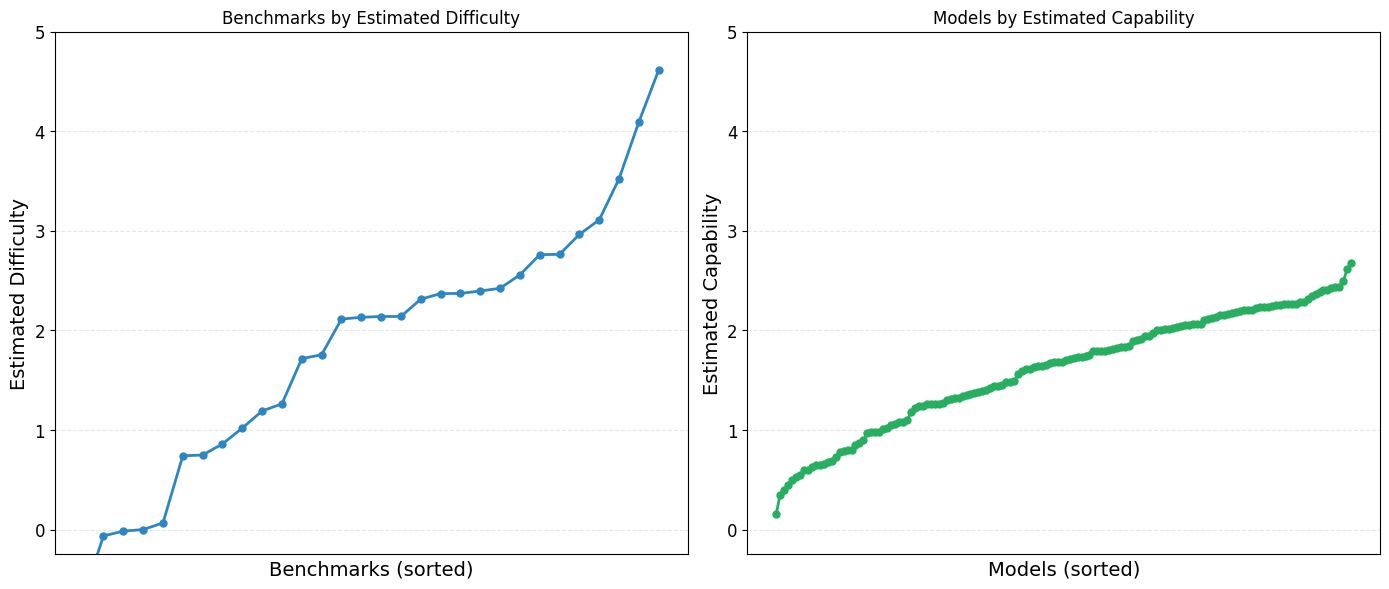

In [ ]:
# ---------- 1) Prepare the two ordered data sets ----------
# ------------- (exactly as in your originals) -------------
sorted_bd = df_db1.sort_values(by="estimated_difficulty").reset_index(drop=True)
bd_values  = sorted_bd["estimated_difficulty"]
bd_names   = sorted_bd["benchmark_name"]
bd_ids     = sorted_bd["benchmark_id"]
bd_idx     = np.arange(len(bd_values))

sorted_cm = df_cm1.sort_values(by="estimated_capability").reset_index(drop=True)
cm_values  = sorted_cm["estimated_capability"]
cm_names   = sorted_cm["model"]
cm_ids     = sorted_cm["model_id"]
cm_idx     = np.arange(len(cm_values))

# ---------- 2) Create a single figure with two sub-axes ----------
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(14, 8), sharey=False  # sharey=False because scales differ
)

# ---------- 3) First subplot: benchmark difficulties ----------
ax1.plot(bd_idx, bd_values, marker='o', linestyle='-', linewidth=2,
         markersize=5, color='#2E86C1')
ax1.set_xlabel('Benchmarks (sorted)', fontsize=14)
ax1.set_ylabel('Estimated Difficulty', fontsize=14)
ax1.set_title('Benchmarks by Estimated Difficulty')
# ax1.set_xticks(bd_idx)
# ax1.set_xticklabels(bd_ids, rotation=90)
ax1.set_xticks([])
ax1.grid(True, alpha=0.3, linestyle='--')
# ax1.axhspan(bd_values.min(), bd_values.max(), alpha=0.1, color='skyblue')

ax1.set_ylim(-0.25, 5)
ax1.tick_params(axis='y', labelsize=12)

# # optional min / max call-outs
# ax1.annotate(f'Min: {bd_values.min():.2f}', xy=(0, bd_values.min()),
#              xytext=(10, 20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)
# ax1.annotate(f'Max: {bd_values.max():.2f}', xy=(len(bd_values)-1, bd_values.max()),
#              xytext=(-50, -20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)

# ---------- 4) Second subplot: model capabilities ----------
ax2.plot(cm_idx, cm_values, marker='o', linestyle='-', linewidth=2,
         markersize=5, color='#27AE60')
ax2.set_xlabel('Models (sorted)', fontsize=14)
ax2.set_ylabel('Estimated Capability', fontsize=14)
ax2.set_title('Models by Estimated Capability')
# ax2.set_xticks(cm_idx)
# ax2.set_xticklabels(cm_ids, rotation=90)
ax2.set_xticks([])
ax2.grid(True, alpha=0.3, linestyle='--')
# ax2.axhspan(cm_values.min(), cm_values.max(), alpha=0.1, color='lightgreen')

ax2.set_ylim(-0.25, 5)
ax2.tick_params(axis='y', labelsize=12)

# ax2.annotate(f'Min: {cm_values.min():.2f}', xy=(0, cm_values.min()),
#              xytext=(10, 20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)
# ax2.annotate(f'Max: {cm_values.max():.2f}', xy=(len(cm_values)-1, cm_values.max()),
#              xytext=(-50, -20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)

# ---------- 5) Finish up ----------
# fig.suptitle('Benchmark Difficulty vs. Model Capability', fontsize=16, y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])   # leave room for the suptitle
plt.subplots_adjust(bottom=0.25)         # extra space for x-tick labels

plt.savefig("outputs/notebooks/model_and_benchmark_ranking.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
set(df1["benchmark"])

{'ANLI',
 'ARC AI2',
 'ARC-AGI',
 'Aider polyglot',
 'BBH',
 'Balrog',
 'BoolQ',
 'CadEval',
 'Cybench',
 'DeepResearch Bench',
 'Factorio learning environment',
 'FrontierMath-2025-02-28-Private',
 'GPQA diamond',
 'GSO-Bench',
 'GeoBench',
 'HellaSwag',
 'MATH level 5',
 'MMLU',
 'OSUniverse',
 'OSWorld',
 'OTIS Mock AIME 2024-2025',
 'OpenBookQA',
 'SWE-Bench verified',
 'SimpleBench',
 'Terminal Bench',
 'TriviaQA',
 'VPCT',
 'VideoMME',
 'WeirdML',
 'Winogrande'}